In [3]:
import sys
sys.path.append(r'H:\My Drive\2022\GitHub\pyMELTScalc\MELTS')
from meltsdynamic import MELTSdynamic
from meltsengine import MELTSengine
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from meltsplotter import MELTSplotter
import sys, os
import shutil
import tempfile
from collections import OrderedDict
from pathlib import Path
import deepdish as dd
import itertools
%matplotlib inline
import time
import random
import pyMELTScalc as M
import re
from matplotlib.cm import get_cmap
from cmcrameri import cm
import Thermobar as pt
import distinctipy
import PySulfSat as ss

In [21]:
file = pd.read_csv('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/MELTs/pyMELTScalc-master/Examples/CrystallisationTests/SchmidtVan_scss.csv')
header = file.columns.values.tolist()
file

,P,Temp,FMQ,CO2,SiO2,TiO2,Al2O3,FeO,Fe2O3,MgO,...,Na2O,K2O,MnO,P2O5,H2O,Cr2O5,NiO,Ni,Cu,FeOt
0,2000,1350,0,0.1,49.2,0.69,12.9,7.2689,2.6907,12.93,...,1.99,0.97,0.2,0.2,1,0,0,20,30,9.9596


In [43]:
bulk = file.iloc[0].values.tolist()

h2o = [0.1,1.0]
fe3fet = [0.1,0.15,0.2] 
emptydf = pd.DataFrame()

for i in range(len(h2o)):
    bulk[15] = h2o[i]
    for j in range(len(fe3fet)):
        bulk[3] = fe3fet[j]
        emptydf = emptydf.append(pd.DataFrame([bulk]), ignore_index=True)

emptydf.columns = header
emptydf = emptydf[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MgO', 'CaO', 'Na2O', 'K2O','MnO', 'P2O5', 'H2O','CO2']]
emptydf.columns = [str(col) + '_Liq' for col in emptydf.columns]
emptydf = emptydf.rename(columns={'CO2_Liq':'Fe3Fet_Liq'})

In [46]:
emptydf['dictindex'] = 'H2O_' + emptydf['H2O_Liq'].astype(str)  + '_' +'Fe3Fet_' + emptydf['Fe3Fet_Liq'].astype(str)


In [47]:
emptydf

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,MnO_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,dictindex
0,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.10,H2O_0.1_Fe3Fet_0.1
1,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.15,H2O_0.1_Fe3Fet_0.15
2,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,0.1,0.20,H2O_0.1_Fe3Fet_0.2
3,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.10,H2O_1.0_Fe3Fet_0.1
4,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.15,H2O_1.0_Fe3Fet_0.15
5,49.2,0.69,12.9,9.9596,12.93,11.21,1.99,0.97,0.2,0.2,1.0,0.20,H2O_1.0_Fe3Fet_0.2


In [56]:
P_lin =([2000.0,1000.0])
P_results = {}
for i in range(len(P_lin)):
    P_bar = P_lin[i]
    Results = M.multi_path(cores=4,Model = "MELTSv1.2.0", comp = emptydf, Frac_solid = True, Frac_fluid = True, T_end_C = 700, dt_C = 5,
                      P_bar = P_bar,  Fe3Fet_Liq = None, H2O_Liq = None, find_liquidus = True)
    P_results['P = ' + str(P_lin[i]) + ' bars'] = Results

Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 8.25 seconds)
Running MELTSv1.2.0 calculations 4 to 5.0 ... Complete (time taken = 6.34 seconds)



Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 6.5 seconds)
Running MELTSv1.2.0 calculations 4 to 5.0 ... Complete (time taken = 6.13 seconds)



In [58]:
P_results.keys()

dict_keys(['P = 2000.0 bars', 'P = 1000.0 bars'])

In [60]:
empty = pd.DataFrame() 

for key in P_results:
    # p_dict is a dictionary of a single pressure 
    p_dict = P_results[key]
    final_dict = p_dict
    for key in final_dict:
        new = final_dict[key]['All']
        new['dictindex'] = key
        new[['pressure_bar', 'T_C']] = final_dict[key]['Conditions'][['P_bar','T_C']]
        empty = empty.append(new)
empty.dictindex.unique()

array(['index = 0', 'index = 1', 'index = 2', 'index = 3', 'index = 5',
       'index = 4'], dtype=object)

In [61]:
emptydf['index'] = emptydf.index #caveats w this format, change 
newkeys = emptydf[['index','dictindex']]
newkeys

,index,dictindex
0,0,H2O_0.1_Fe3Fet_0.1
1,1,H2O_0.1_Fe3Fet_0.15
2,2,H2O_0.1_Fe3Fet_0.2
3,3,H2O_1.0_Fe3Fet_0.1
4,4,H2O_1.0_Fe3Fet_0.15
5,5,H2O_1.0_Fe3Fet_0.2


In [62]:
empty_index = empty.reset_index()

In [63]:
empty_index['newentry'] = empty_index['dictindex'].str.extract('(\d+)')
empty_index['newentry'] 

0       0
1       0
2       0
3       0
4       0
       ..
1106    5
1107    5
1108    5
1109    5
1110    5
Name: newentry, Length: 1111, dtype: object

In [64]:
empty_index['newcolumn'] = 0
for i in range(len(empty_index)):
    empty_index['newentry'][i] = float(empty_index['newentry'][i])
    empty_index['newcolumn'][i] = newkeys['dictindex'][empty_index['newentry'][i]]
empty_index.shape

<ipython-input-64-69e151919c31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_index['newentry'][i] = float(empty_index['newentry'][i])
<ipython-input-64-69e151919c31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_index['newcolumn'][i] = newkeys['dictindex'][empty_index['newentry'][i]]
/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self

(1111, 270)

In [65]:
empty_index['unique'] = 'P_'+ empty_index['P_bar'].astype(str) + '_' + empty_index['newcolumn'].astype(str)

empty_index.newcolumn.unique(), empty_index.unique.unique() #if run at 2 pressures there should be double the categories of newcolumn


(array(['H2O_0.1_Fe3Fet_0.1', 'H2O_0.1_Fe3Fet_0.15', 'H2O_0.1_Fe3Fet_0.2',
        'H2O_1.0_Fe3Fet_0.1', 'H2O_1.0_Fe3Fet_0.2', 'H2O_1.0_Fe3Fet_0.15'],
       dtype=object),
 array(['P_2000.0_H2O_0.1_Fe3Fet_0.1', 'P_2000.0_H2O_0.1_Fe3Fet_0.15',
        'P_2000.0_H2O_0.1_Fe3Fet_0.2', 'P_2000.0_H2O_1.0_Fe3Fet_0.1',
        'P_2000.0_H2O_1.0_Fe3Fet_0.2', 'P_2000.0_H2O_1.0_Fe3Fet_0.15',
        'P_1000.0_H2O_0.1_Fe3Fet_0.1', 'P_1000.0_H2O_0.1_Fe3Fet_0.2',
        'P_1000.0_H2O_0.1_Fe3Fet_0.15', 'P_1000.0_H2O_1.0_Fe3Fet_0.1',
        'P_1000.0_H2O_1.0_Fe3Fet_0.15', 'P_1000.0_H2O_1.0_Fe3Fet_0.2'],
       dtype=object))

### Calculate the S solubility for different species

In [66]:
Smythe_CalcSulf=ss.calculate_S2017_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15,
                                             P_kbar=empty_index['pressure_bar']/1000, Fe_FeNiCu_Sulf=0.65,
                                             Fe3Fet_Liq=empty_index['Fe3Fet_Liq'])


Using inputted Fe_FeNiCu_Sulf ratio for calculations.
You havent entered a value for Ni_FeNiCu_Sulf and Cu_FeNiCu_Sulf so we cant calculate the non-ideal SCSS


Text(0, 0.5, 'SCSS (Smythe, ppm)')

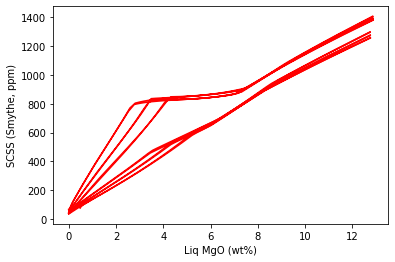

In [67]:
plt.plot(empty_index['MgO_Liq'], Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017'],'-r')
plt.xlabel('Liq MgO (wt%)')
plt.ylabel('SCSS (Smythe, ppm)')

In [68]:
LiZhang22=ss.calculate_LZ2022_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15, 
P_kbar=empty_index['pressure_bar']/1000,Fe_FeNiCu_Sulf=0.65,Fe3Fet_Liq=empty_index['Fe3Fet_Liq'], H2O_Liq=empty_index['H2O_Liq'])
LiZhang22.head()

replacing Fe3Fet_Liq in the original dataframe with that input into the function


,SCSS_Tot,index,T_C,P_bar,h,s,v,SiO2_Liq,TiO2_Liq,Al2O3_Liq,...,Al_cat,Fe_cat,Mn_cat,Mg_cat,Ca_cat,Na_cat,K_cat,P_cat,H_cat,Fe3_cat
0,1248.834187,0,1332.600000,2000.0,-1.193085e+06,280.936337,36.850411,48.974802,0.686842,12.840954,...,0.138243,0.068209,0.001540,0.175268,0.109213,0.035083,0.011252,0.001540,0.0,0.007569
1,1232.124583,1,1327.618898,2000.0,-1.194147e+06,280.274227,36.823850,49.025555,0.690968,12.918106,...,0.139166,0.068156,0.001538,0.172534,0.109916,0.035317,0.011327,0.001550,0.0,0.007619
2,1215.395882,2,1322.637795,2000.0,-1.187716e+06,278.097309,36.611102,49.077071,0.695143,12.996144,...,0.140100,0.068096,0.001535,0.169775,0.110626,0.035554,0.011403,0.001560,0.0,0.007670
3,1198.790142,3,1317.656693,2000.0,-1.181265e+06,275.926107,36.398571,49.128391,0.699286,13.073615,...,0.141028,0.068029,0.001532,0.167043,0.111332,0.035790,0.011479,0.001571,0.0,0.007721
4,1182.308056,4,1312.675591,2000.0,-1.174951e+06,273.792250,36.190159,49.179514,0.703400,13.150519,...,0.141950,0.067955,0.001529,0.164336,0.112032,0.036024,0.011554,0.001581,0.0,0.007772


In [70]:
ZT22_SCAS=ss.calculate_ZT2022_SCAS(df=empty_index, T_K=empty_index['T_C']+273.15)

In [94]:
empty_index['Calc SCAS (ppm)']=ZT22_SCAS['Calc SCAS (ppm)']
empty_index['SCSS_Tot'] = LiZhang22['SCSS_Tot']

In [72]:
LiZha_ST_Nash=ss.calculate_S_Total_SCSS_SCAS(Fe3Fet_Liq=empty_index['Fe3Fet_Liq'],
    SCSS=LiZhang22['SCSS_Tot'],
    T_K=empty_index['T_C']+273.15,
    SCAS=ZT22_SCAS['Calc SCAS (ppm)'], model='Nash')
LiZha_ST_Nash.head()

,Total_S,S2_Tot,S6_Tot,deltaQFM,S6_St,SCSS_2,SCAS_6,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,1322.903026,1248.834187,74.068838,None,0.055990,1248.834187,14606.688729,1322.903026,260882.081514,74.068838,246275.392785
1,1304.073504,1232.124583,71.948921,None,0.055172,1232.124583,14166.890581,1304.073504,256774.757159,71.948921,242607.866578
2,1285.335774,1215.395882,69.939892,None,0.054414,1215.395882,13740.958218,1285.335774,252527.486400,69.939892,238786.528182
3,1266.757605,1198.790142,67.967463,None,0.053655,1198.790142,13331.348440,1266.757605,248465.753712,67.967463,235134.405272
4,1248.340121,1182.308056,66.032065,None,0.052896,1182.308056,12937.267606,1248.340121,244579.814479,66.032065,231642.546873


In [102]:
empty_index['Total_S'] = LiZha_ST_Nash['Total_S']
empty_index['S6_St'] = LiZha_ST_Nash['S6_St']

Text(0.5, 0, 'Fe3Fet')

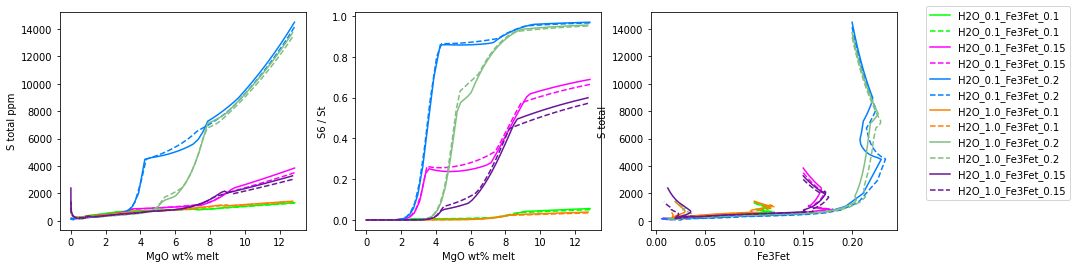

In [112]:
pressure = [1000.0,2000.0]

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4), sharex = False)

scalarmap = dict(zip(empty_index.newcolumn.unique(), distinctipy.get_colors(10)))

pressure = empty_index['pressure_bar'].unique()
lines = ['solid', 'dashed']
pdict = dict(zip(pressure, lines))

for i in empty_index.newcolumn.unique():
    df = empty_index[empty_index.newcolumn == i]
    for p in pressure:
        df_p = df[df.pressure_bar ==p]
        
        x = df_p['MgO_Liq']
        y = df_p['Total_S']
        ax1.plot(x,y,color=scalarmap[i], label=i, linestyle=pdict[p])
        
        ax2.plot(x, df_p['S6_St'],color=scalarmap[i], label=i, linestyle=pdict[p])
        ax3.plot(df_p['Fe3Fet_Liq'], y,color=scalarmap[i], label=i, linestyle=pdict[p])
        
ax3.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel('S total ppm')
ax2.set_ylabel('S6 / St')
ax1.set_xlabel('MgO wt% melt')
ax2.set_xlabel('MgO wt% melt')
ax3.set_ylabel('S total')
ax3.set_xlabel('Fe3Fet')


In [104]:
empty_index[empty_index.unique.isin(['P_2000.0_H2O_0.1_Fe3Fet_0.2'])][[ 'Fe2O3_Liq', 'FeO_Liq', 'FeOt_Liq','Fe3Fet_Liq','mass_Liq','Total_S','Calc SCAS (ppm)','SCSS_Tot', 'S6_St']]



,Fe2O3_Liq,FeO_Liq,FeOt_Liq,Fe3Fet_Liq,mass_Liq,Total_S,Calc SCAS (ppm),SCSS_Tot,S6_St
153,2.199826,7.922518,9.914380,0.199648,100.000000,14495.046094,14074.580446,1142.567086,9.709925e-01
154,2.212607,7.910035,9.913470,0.200827,99.422356,14066.748052,13652.025813,1126.707482,9.705175e-01
155,2.225295,7.896887,9.911810,0.202012,98.855511,13654.643744,13245.392486,1110.985263,9.700284e-01
156,2.237881,7.883090,9.909409,0.203204,98.299506,13258.052763,12853.997541,1095.404173,9.695238e-01
157,2.250368,7.868649,9.906275,0.204402,97.754081,12876.232713,12477.111942,1079.964139,9.690033e-01
...,...,...,...,...,...,...,...,...,...
227,0.050350,4.776389,4.821978,0.009395,9.651392,112.471885,701.369471,112.471885,2.098511e-13
228,0.043667,4.715518,4.755057,0.008263,9.227655,124.575759,681.202256,124.575759,6.716508e-14
229,0.036115,4.647125,4.679826,0.006944,8.843065,137.570864,661.001040,137.570864,1.491043e-14
230,0.028102,4.610891,4.636336,0.005454,8.508286,151.144815,641.938590,151.144815,1.923606e-15


Text(0.5, 0, 'MgO wt% melt')

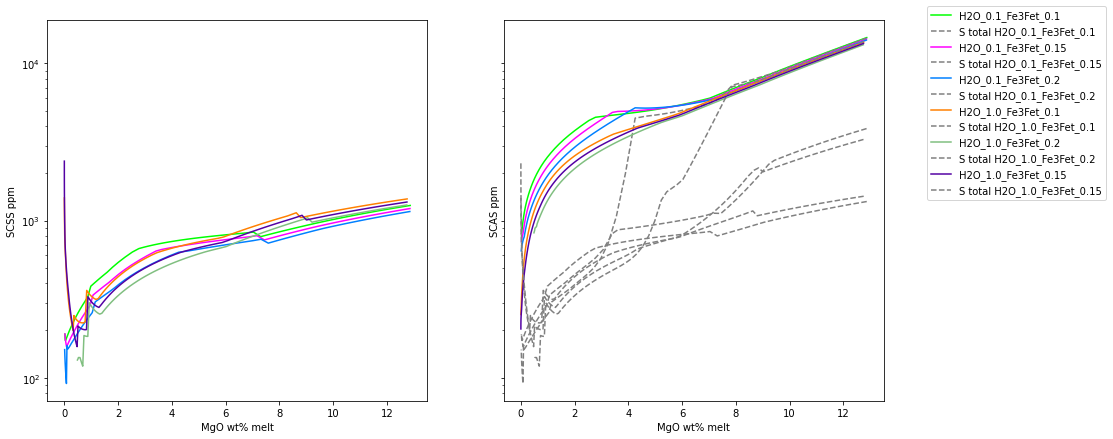

In [131]:
pressure = [2000.0] #bars

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7), sharey = True)

scalarmap = dict(zip(empty_index.newcolumn.unique(), distinctipy.get_colors(10)))


lines = ['solid', 'dashed']
pdict = dict(zip(pressure, lines))

for i in empty_index.newcolumn.unique():
    df = empty_index[empty_index.newcolumn == i]
    for p in pressure:
        df_p = df[df.pressure_bar ==p]
        
        x = df_p['MgO_Liq']
        y = df_p['SCSS_Tot']
        ax1.plot(x,y,color=scalarmap[i], label=i, linestyle=pdict[p])
        #ax1.plot(x,df_p['Total_S'],color='grey', linestyle='dashed', label=('S total '+i))
        
        ax2.plot(x, df_p['Calc SCAS (ppm)'],color=scalarmap[i], label=i, linestyle=pdict[p])
        ax2.plot(x,df_p['Total_S'],color='grey', linestyle='dashed', label=('S total '+i))
        
        
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel('SCSS ppm')
ax2.set_ylabel('SCAS ppm')
ax1.set_xlabel('MgO wt% melt')
ax2.set_xlabel('MgO wt% melt')


In [300]:
import Thermobar as pt

load = pt.import_excel('/Users/ollie/Downloads/1-s2.0-S0012821X22004721-mmc3.xlsx', sheet_name='Thermobar_input', suffix='_Liq')
offsets = pd.read_excel('/Users/ollie/Downloads/1-s2.0-S0012821X22004721-mmc3.xlsx', sheet_name='Thermobar_input')

rawglobal = pd.read_excel('/Users/ollie/Downloads/1-s2.0-S0012821X22004721-mmc3.xlsx', sheet_name='GlobalDat_XANES')

In [301]:
globaldat = rawglobal[~rawglobal['Sample Name'].isin(['2σ'])]

In [302]:
Liqs=load['Liqs']
Liqs

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq
0,48.230000,0.960000,16.830000,8.880000,0.110000,10.130000,10.570000,2.720000,0.262000,0.0,0.160000,1.040000,0.0,0.0,0.0,0.0,0
1,49.040000,0.930000,16.480000,8.880000,0.125000,9.860000,10.550000,2.540000,0.267000,0.0,0.160000,1.080000,0.0,0.0,0.0,0.0,1
2,48.590000,0.970000,16.620000,8.880000,0.114000,9.760000,10.640000,2.800000,0.272000,0.0,0.150000,1.120000,0.0,0.0,0.0,0.0,2
3,49.080000,0.720000,15.720000,8.540000,0.094000,9.470000,10.130000,2.410000,0.481000,0.0,0.100000,3.110000,0.0,0.0,0.0,0.0,3
4,48.310000,0.700000,15.890000,8.540000,0.079000,10.320000,10.730000,2.360000,0.381000,0.0,0.090000,2.450000,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,53.254392,1.062321,17.716975,10.446382,0.147522,4.479291,9.752261,2.375111,0.345540,0.0,0.126939,2.307244,0.0,0.0,0.0,0.0,557
558,54.449948,0.935711,15.636843,11.654875,0.199752,3.727104,8.982714,2.464845,0.338854,0.0,0.142291,3.305897,0.0,0.0,0.0,0.0,558
559,52.798704,1.060845,16.366452,12.561006,0.239473,4.764424,9.281775,1.873960,0.368410,0.0,0.114130,2.746400,0.0,0.0,0.0,0.0,559
560,49.017695,1.097265,15.906396,12.259500,0.187743,5.057692,12.332504,2.383186,0.156237,0.0,0.151686,1.602556,0.0,0.0,0.0,0.0,560


In [303]:
offsets['Offset']

0      0.398955
1      0.445185
2      0.458622
3      0.460177
4      0.361257
         ...   
557    0.750013
558    0.523440
559    0.624111
560    0.253241
561    0.451255
Name: Offset, Length: 562, dtype: float64

In [304]:
# pick thermometer and calc temperature

T_HT87=pt.calculate_liq_only_temp(liq_comps=Liqs, equationT='T_Helz1987_MgO')

In [305]:
myLiquids_Fe3_Kress_norm_NNO1=pt.convert_fo2_to_fe_partition(liq_comps=Liqs, T_K=T_HT87,
                            P_kbar=3, fo2="QFM", fo2_offset=offsets['Offset'], model="Kress1991", renorm=True)
myLiquids_Fe3_Kress_norm_NNO1


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq
0,48.655042,0.968465,16.978404,1.688463,7.438178,0.110970,10.219325,10.663205,2.743985,0.264310,0.161411,0.169610
1,49.490933,0.938556,16.631620,1.712363,7.420057,0.126150,9.950714,10.647063,2.563369,0.269456,0.161472,0.171946
2,49.054978,0.979287,16.779127,1.746074,7.393029,0.115091,9.853447,10.741872,2.826808,0.274604,0.151436,0.175267
3,50.572169,0.741894,16.198013,1.686919,7.280949,0.096858,9.757963,10.438032,2.483283,0.495626,0.103041,0.172510
4,49.444660,0.716445,16.263291,1.623497,7.278988,0.080856,10.562439,10.982071,2.415442,0.389951,0.092114,0.167146
...,...,...,...,...,...,...,...,...,...,...,...,...
557,54.367222,1.084526,18.087288,2.238888,8.649056,0.150605,4.572915,9.956099,2.424755,0.352762,0.129593,0.188918
558,56.149157,0.964917,16.124899,2.311873,9.937266,0.205986,3.843435,9.263082,2.541777,0.349431,0.146732,0.173100
559,54.126952,1.087538,16.778264,2.453040,10.668593,0.245499,4.884306,9.515322,1.921113,0.377680,0.117002,0.171425
560,49.700138,1.112547,16.127931,2.307030,10.353222,0.190358,5.128132,12.504264,2.416377,0.158413,0.153798,0.167017


In [306]:
from sklearn.linear_model import LinearRegression
#plt.scatter(offsets['H2O'], myLiquids_Fe3_Kress_norm_NNO1['Fe3Fet_Liq'])
x = offsets['H2O'].replace(np.nan, 0)
x = x.values.reshape(len(x),1)
y = myLiquids_Fe3_Kress_norm_NNO1['Fe3Fet_Liq']
reg = LinearRegression(fit_intercept=True)
reg = reg.fit(x,y) #cant have nans
ypred = reg.predict(x)



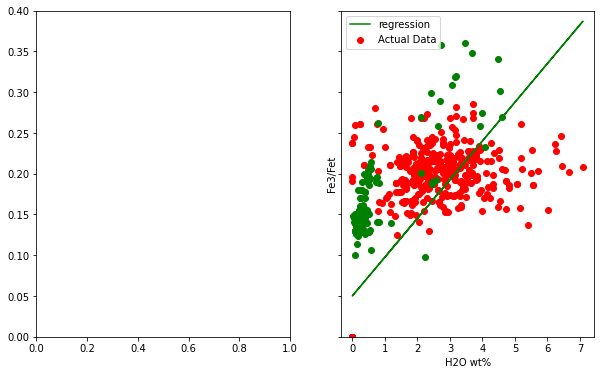

In [307]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6), sharey=True)

ax2.plot(x, ypred, color='green', label='regression')
ax2.scatter(x, y, c='red', label='Actual Data')
ax2.set_ylim(0.0,0.4)
m = (reg.coef_)
# find the value of b (the constant/intercept) 
c =(reg.intercept_)
ax2.legend()




#ax2b.scatter(x, offsets['Offset'], c=None, label='Actual Data')
#ax2b.set_ylabel('QFM offset')
ax2.set_ylabel('Fe3/Fet')
ax2.set_xlabel('H2O wt%')



ax2.scatter(globaldat['H2O'], globaldat['Fe3Fet_Liq'],c='green')

#ax1b.scatter(globaldat['H2O'], globaldat['Offset'],c='black')


In [308]:
print(m,c)

[0.04751585] 0.05014636768739038


In [317]:
myLiquids_Fe3_Kress_norm_NNO1[['SiO2_Liq','MgO_Liq','Fe3Fet_Liq']]
myLiquids_Fe3_Kress_norm_NNO1['H2O'] = offsets['H2O']
myLiquids_Fe3_Kress_norm_NNO1['Tect Setting'] = offsets['Tect Setting']
myLiquids_Fe3_Kress_norm_NNO1['Paper'] = offsets['Paper']
comp = pd.concat([globaldat[['SiO2_Liq','MgO_Liq','Fe3Fet_Liq', 'H2O', 'Tect Setting','Paper']],myLiquids_Fe3_Kress_norm_NNO1[['SiO2_Liq','MgO_Liq','Fe3Fet_Liq','H2O','Tect Setting', 'Paper']]], ignore_index=True)
           
           
           
           

/Users/ollie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='H2O', ylabel='Fe3Fet_Liq'>

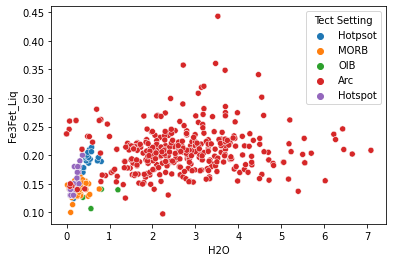

In [318]:
import seaborn as sns
sns.scatterplot(comp['H2O'], comp['Fe3Fet_Liq'], hue=comp['Tect Setting'])

In [332]:
comp_1 = comp[~comp.H2O.isin([np.nan])]
comp_2 = comp_1[~comp_1.Fe3Fet_Liq.isin([np.nan])]

In [333]:
x = comp_2['H2O']
x = x.values.reshape(len(x),1)
y = comp_2['Fe3Fet_Liq']
reg = LinearRegression(fit_intercept=True)
reg = reg.fit(x,y) #cant have nans
ypred = reg.predict(x)


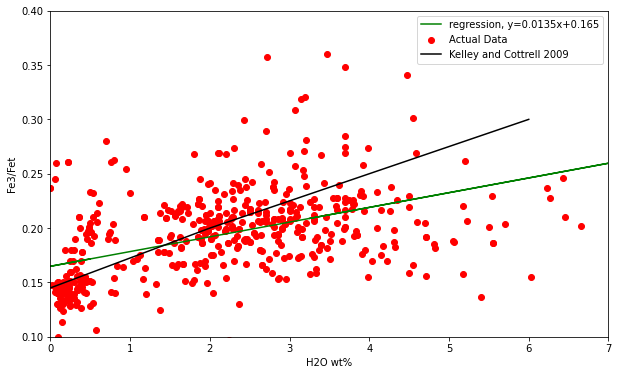

In [347]:
fig, (ax2) = plt.subplots(1, 1, figsize=(10,6), sharey=True)

ax2.plot(x, ypred, color='green', label='regression, y=0.0135x+0.165')
ax2.scatter(x, y, c='red', label='Actual Data')
ax2.set_ylim(0.1,0.4)
ax2.set_xlim(0,7)
m = (reg.coef_)
# find the value of b (the constant/intercept) 
c =(reg.intercept_)


ax2.set_ylabel('Fe3/Fet')
ax2.set_xlabel('H2O wt%')

ax2.plot([6,2,0],[0.3,0.2,0.145], c='k', label='Kelley and Cottrell 2009')
ax2.legend()

In [344]:
m,c

(array([0.01354077]), 0.16486979702959864)

# Practicing with S6+/St PySulf sat example with their data
trying to understand the outputs

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PySulfSat as ss
import Thermobar as pt
pd.options.display.max_columns = None

In [5]:
SCSS=1000
SCAS=5000
DeltaQFM_lin=np.linspace(-1, 3, 10001)
QFM_point1=DeltaQFM_lin==-1
QFM_point2=DeltaQFM_lin==1
QFM_point4=DeltaQFM_lin==2


df_Species=ss.calculate_S_Total_SCSS_SCAS(deltaQFM=DeltaQFM_lin,
            SCSS=SCSS, SCAS=SCAS, model='Jugo')

df_Species.head()

,Total_S,S2_Tot,S6_Tot,deltaQFM,S6_St,SCSS_2,SCAS_6,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,1000.079433,1000.0,0.079433,-1.0000,0.000079,1000,5000,1000.079433,6.295127e+07,0.079433,6.294627e+07
1,1000.079579,1000.0,0.079579,-0.9996,0.000080,1000,5000,1000.079579,6.283543e+07,0.079579,6.283043e+07
2,1000.079726,1000.0,0.079726,-0.9992,0.000080,1000,5000,1000.079726,6.271979e+07,0.079726,6.271479e+07
3,1000.079873,1000.0,0.079873,-0.9988,0.000080,1000,5000,1000.079873,6.260438e+07,0.079873,6.259938e+07
4,1000.080020,1000.0,0.080020,-0.9984,0.000080,1000,5000,1000.080020,6.248917e+07,0.080020,6.248417e+07


In [6]:
DeltaQFM_lin

array([-1.    , -0.9996, -0.9992, ...,  2.9992,  2.9996,  3.    ])

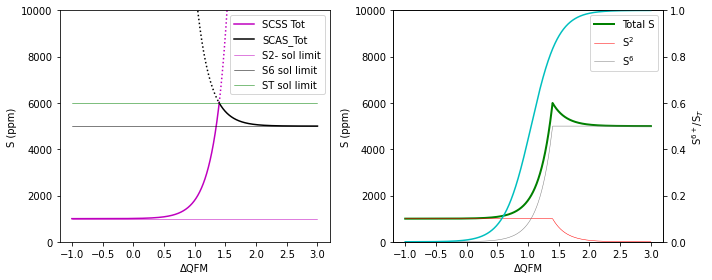

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
SCSS_Tot_excessS6=df_Species['S6 in SCSS_Tot']>df_Species['SCAS_6']

ax1.plot(df_Species['deltaQFM'].loc[~SCSS_Tot_excessS6],
         df_Species['SCSS_Tot'].loc[~SCSS_Tot_excessS6], '-m', label='SCSS Tot')

ax1.plot(df_Species['deltaQFM'].loc[SCSS_Tot_excessS6],
         df_Species['SCSS_Tot'].loc[SCSS_Tot_excessS6], ':m')

SCAS_Tot_excessS2=df_Species['S2 in SCAS_Tot']>df_Species['SCSS_2']

ax1.plot(df_Species['deltaQFM'].loc[~SCAS_Tot_excessS2],
         df_Species['SCAS_Tot'].loc[~SCAS_Tot_excessS2], '-k', label='SCAS_Tot')
ax1.plot(df_Species['deltaQFM'].loc[SCAS_Tot_excessS2],
         df_Species['SCAS_Tot'].loc[SCAS_Tot_excessS2], ':k')

ax1.plot([-1, 3], [SCSS, SCSS], '-m', lw=0.5, label='S2- sol limit')
ax1.plot([-1, 3], [SCAS, SCAS], '-k', lw=0.5, label='S6 sol limit')
ax1.plot([-1, 3], [SCAS+SCSS, SCAS+SCSS], '-g', lw=0.5, label='ST sol limit')
ax1.legend()
#ax1.legend()

maxS=SCSS+SCAS
maxX=df_Species['deltaQFM'].loc[df_Species['Total_S']==maxS]
ax2.plot(df_Species['deltaQFM'], df_Species['Total_S'], '-g', lw=2, label='Total S')

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
ax2b=ax2.twinx()
ax2.plot(df_Species['deltaQFM'], df_Species['S2_Tot'], '-r', lw=0.5, label='S$^{2}$')
ax2.plot(df_Species['deltaQFM'], df_Species['S6_Tot'], '-', color='grey', lw=0.5, label='S$^{6}$')

ax2b.plot(df_Species['deltaQFM'], df_Species['S6_St'], '-c', label='S$^{6}$/$_{T}$')
ax2.legend()
ax2b.plot([maxX, maxX], [0, 1], ':c')
ax1.set_ylim([0, 10000])
ax2.set_ylim([0, 10000])
ax2b.set_ylim([0, 1])
ax1.set_ylabel('S (ppm)')
ax2.set_ylabel('S (ppm)')
ax1.set_xlabel('ΔQFM')
ax2.set_xlabel('ΔQFM')
ax2b.set_ylabel('S$^{6+}$/S$_{T}$')
fig.tight_layout()
fig.savefig('SCSS_SCAS.png', dpi=300)

In [8]:
df_out=ss.import_data('/Users/ollie/Downloads/PetrologCalculations.xlsx', Petrolog=True)
df_out.head()

We have replaced all missing liquid oxides and strings with zeros. 


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,Ni_Liq_ppm,Cu_Liq_ppm,SiO2_magma,TiO2_magma,Al2O3_magma,Fe2O3_magma,FeO_magma,MnO_magma,MgO_magma,CaO_magma,Na2O_magma,K2O_magma,P2O5_magma,Cr2O3_magma,Ni_magma,Cu_magma,Cr2O3_Liq,Ni_Liq,Cu_Liq,SiO2_cumulate,TiO2_cumulate,Al2O3_cumulate,Fe2O3_cumulate,FeO_cumulate,MnO_cumulate,MgO_cumulate,CaO_cumulate,Na2O_cumulate,K2O_cumulate,P2O5_cumulate,Cr2O3_cumulate,Ni_cumulate,Cu_cumulate,Temperature,Temperature_Olv,Olv_Fo_magma,Olv_Kd,Olv_Fo_cumulate,Pressure(kbar),Lg(fO2),dNNO,density,Ln(viscosity),Melt_%_magma,Olv_%_magma,Olv_Peritectic,Fluid_%_magma,Olv_%_cumulate,Sample,Unnamed:58,T_K,P_kbar
0,49.9010,0.9981,14.9715,8.980926,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0,0.098489,697.8,99.8,49.9010,0.9981,14.9715,0.9839,8.0964,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0998,697.8,99.8,0.0998,697.8,99.8,40.2986,0,0,0,11.7372,0,46.9121,0,0,0,0,0,8257.6,10.0,1253.281,1253.281,87.69,0.308,87.69,1,-7.72,-0.7,2.683,6.25,99.9900,0,N,0,0.0100,PetrologDefault,08:21:15,1526.431,1
1,49.9978,1.0081,15.1220,8.951296,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.0,0.097851,624.6,100.7,49.9978,1.0081,15.1220,0.9743,8.0754,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.1008,624.6,100.7,0.1008,624.6,100.7,40.2698,0,0,0,11.9273,0,46.7855,0,0,0,0,0,7984.5,10.0,1243.430,1243.430,87.28,0.309,87.49,1,-7.83,-0.7,2.682,6.38,98.9950,0,N,0,1.0050,PetrologDefault,08:21:15,1516.580,1
2,50.0982,1.0185,15.2770,8.916645,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.0,0.097284,554.8,101.6,50.0982,1.0185,15.2770,0.9649,8.0492,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.1018,554.8,101.6,0.1018,554.8,101.6,40.2390,0,0,0,12.1280,0,46.6507,0,0,0,0,0,7708.8,10.1,1233.064,1233.064,86.83,0.310,87.27,1,-7.94,-0.7,2.681,6.52,97.9904,0,N,0,2.0096,PetrologDefault,08:21:15,1506.214,1
3,50.2003,1.0289,15.4337,8.877334,0.1029,8.8486,12.3469,2.5723,0.2058,0.1029,0.0,0.096823,489.9,102.6,50.2003,1.0289,15.4337,0.9561,8.0178,0.1029,8.8486,12.3469,2.5723,0.2058,0.1029,0.1029,489.9,102.6,0.1029,489.9,102.6,40.2069,0,0,0,12.3359,0,46.5096,0,0,0,0,0,7436.5,10.1,1222.361,1222.361,86.36,0.311,87.05,1,-8.05,-0.7,2.680,6.67,96.9959,0,N,0,3.0041,PetrologDefault,08:21:15,1495.511,1
4,50.3062,1.0397,15.5950,8.832002,0.1040,8.4612,12.4760,2.5992,0.2079,0.1040,0.0,0.096445,428.7,103.5,50.3062,1.0397,15.5950,0.9475,7.9802,0.1040,8.4612,12.4760,2.5992,0.2079,0.1040,0.1040,428.7,103.5,0.1040,428.7,103.5,40.1725,0,0,0,12.5558,0,46.3589,0,0,0,0,0,7162.8,10.2,1211.080,1211.080,85.84,0.312,86.81,1,-8.18,-0.7,2.679,6.83,95.9923,0,N,0,4.0077,PetrologDefault,08:21:15,1484.230,1


In [9]:
Smythe_FixedSulf=ss.calculate_S2017_SCSS(df=df_out,
T_K=df_out['T_K'], P_kbar=df_out['P_kbar'],
Fe3Fet_Liq=df_out['Fe3Fet_Liq'],
Fe_FeNiCu_Sulf=0.65)
Smythe_FixedSulf.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
You havent entered a value for Ni_FeNiCu_Sulf and Cu_FeNiCu_Sulf so we cant calculate the non-ideal SCSS


,SCSS_ideal_ppm_Smythe2017,SCSS_ideal_ppm_Smythe2017_1sigma,T_Input_K,P_Input_kbar,Fe_FeNiCu_Sulf,Fe3Fet_Liq_input,Si_wt_atom,Ti_wt_atom,Al_wt_atom,Mg_wt_atom,Mn_wt_atom,Fe2_wt_atom,Fe3_wt_atom,Ca_wt_atom,Na_wt_atom,K_wt_atom,P_wt_atom,H_wt_atom,Si_XA_ideal,Ti_XA_ideal,Al_XA_ideal,Mg_XA_ideal,Fe2_XA_ideal,Ca_XA_ideal,Na_XA_ideal,K_XA_ideal,H_XA_ideal,Si*Fe_ideal,Si_XA_non_ideal,Ti_XA_non_ideal,Al_XA_non_ideal,Mg_XA_non_ideal,Fe2_XA_non_ideal,Ca_XA_non_ideal,Na_XA_non_ideal,K_XA_non_ideal,H_XA_non_ideal,Si*Fe_non_ideal,log_SCSS_ideal,Fe_FeNiCu_Sulf_calc,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,Ni_Liq_ppm,Cu_Liq_ppm,SiO2_magma,TiO2_magma,Al2O3_magma,Fe2O3_magma,FeO_magma,MnO_magma,MgO_magma,CaO_magma,Na2O_magma,K2O_magma,P2O5_magma,Cr2O3_magma,Ni_magma,Cu_magma,Cr2O3_Liq,Ni_Liq,Cu_Liq,SiO2_cumulate,TiO2_cumulate,Al2O3_cumulate,Fe2O3_cumulate,FeO_cumulate,MnO_cumulate,MgO_cumulate,CaO_cumulate,Na2O_cumulate,K2O_cumulate,P2O5_cumulate,Cr2O3_cumulate,Ni_cumulate,Cu_cumulate,Temperature,Temperature_Olv,Olv_Fo_magma,Olv_Kd,Olv_Fo_cumulate,Pressure(kbar),Lg(fO2),dNNO,density,Ln(viscosity),Melt_%_magma,Olv_%_magma,Olv_Peritectic,Fluid_%_magma,Olv_%_cumulate,Sample,Unnamed:58,T_K,P_kbar
0,1163.632126,317.869126,1526.431,1,0.65,0.098489,0.458760,0.006900,0.162217,0.136728,0.000777,0.062247,0.006799,0.117975,0.044478,0.002341,0.000777,0.0,-12643.917846,-77.425761,-2992.954217,-1910.042747,-2133.469827,-923.846254,-589.186980,-67.922629,-0.0,3328.767457,-12843.656196,-73.937634,-3082.117373,-1984.261077,-2172.132780,-1041.911444,-609.912056,-66.914620,-0.0,3364.402871,7.059302,0.65,49.9010,0.9981,14.9715,8.980926,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0,0.098489,697.8,99.8,49.9010,0.9981,14.9715,0.9839,8.0964,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0998,697.8,99.8,0.0998,697.8,99.8,40.2986,0,0,0,11.7372,0,46.9121,0,0,0,0,0,8257.6,10.0,1253.281,1253.281,87.69,0.308,87.69,1,-7.72,-0.7,2.683,6.25,99.9900,0,N,0,0.0100,PetrologDefault,08:21:15,1526.431,1
1,1132.187652,309.279446,1516.580,1,0.65,0.097851,0.460128,0.006977,0.164018,0.131795,0.000786,0.062150,0.006740,0.119285,0.044970,0.002367,0.000785,0.0,-12681.596545,-78.282676,-3026.179002,-1841.131776,-2130.145227,-934.101871,-595.707729,-68.674435,-0.0,3333.484439,-12881.930112,-74.755944,-3116.331958,-1912.672440,-2168.747932,-1053.477703,-616.662177,-67.655269,-0.0,3369.170350,7.031907,0.65,49.9978,1.0081,15.1220,8.951296,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.0,0.097851,624.6,100.7,49.9978,1.0081,15.1220,0.9743,8.0754,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.1008,624.6,100.7,0.1008,624.6,100.7,40.2698,0,0,0,11.9273,0,46.7855,0,0,0,0,0,7984.5,10.0,1243.430,1243.430,87.28,0.309,87.49,1,-7.83,-0.7,2.682,6.38,98.9950,0,N,0,1.0050,PetrologDefault,08:21:15,1516.580,1
2,1099.523987,300.356720,1506.214,1,0.65,0.097284,0.461540,0.007056,0.165875,0.126736,0.000794,0.062014,0.006682,0.120635,0.045480,0.002394,0.000794,0.0,-12720.511949,-79.173986,-3060.433090,-1770.461624,-2125.481450,-944.675207,-602.466551,-69.463239,-0.0,3336.392958,-12921.460271,-75.607099,-3151.606511,-1839.256265,-2163.999637,-1065.402284,-623.658745,-68.432367,-0.0,3372.110005,7.002633,0.65,50.0982,1.0185,15.2770,8.916645,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.0,0.097284,554.8,101.6,50.0982,1.0185,15.2770,0.9649,8.0492,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.1018,554.8,101.6,0.1018,554.8,101.6,40.2390,0,0,0,12.1280,0,46.6507,0,0,0,0,0,7708.8,10.1,1233.064,1233.064,86.83,0.310,87.27,1,-7.94,-0.7,2.681,6.52,97.9904,0,N,0,2.0096,PetrologDefault,08:21:15,1506.214,1
3,1066.279038,291.275205,1495.511,1,0.65,0.096823,0.462968,0.007136,0.167753,0.121655,0.000804,0.061837,0.006628,0.122000,0.045995,0.002421,0.000803,0.0,-12759.875643,-80.066770,-3095.084610,-1699.479235,-2119.422207,-955.366577,-609.283904,-70.253349,-0.0,3337.176747,-12961.445800,-76.459662,-3187.290335,-1765.515721,-2157.830588,-1077.459984,-630.715903,-69.210751,-0.0,3

In [10]:
ZT22_SCAS=ss.calculate_ZT2022_SCAS(df=df_out, T_K=df_out['T_K'])
ZT22_SCAS.head()

,Calc SCAS (ppm),SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,Ni_Liq_ppm,Cu_Liq_ppm,SiO2_magma,TiO2_magma,Al2O3_magma,Fe2O3_magma,FeO_magma,MnO_magma,MgO_magma,CaO_magma,Na2O_magma,K2O_magma,P2O5_magma,Cr2O3_magma,Ni_magma,Cu_magma,Cr2O3_Liq,Ni_Liq,Cu_Liq,SiO2_cumulate,TiO2_cumulate,Al2O3_cumulate,Fe2O3_cumulate,FeO_cumulate,MnO_cumulate,MgO_cumulate,CaO_cumulate,Na2O_cumulate,K2O_cumulate,P2O5_cumulate,Cr2O3_cumulate,Ni_cumulate,Cu_cumulate,Temperature,Temperature_Olv,Olv_Fo_magma,Olv_Kd,Olv_Fo_cumulate,Pressure(kbar),Lg(fO2),dNNO,density,Ln(viscosity),Melt_%_magma,Olv_%_magma,Olv_Peritectic,Fluid_%_magma,Olv_%_cumulate,Sample,Unnamed:58,T_K,P_kbar
0,8797.905353,49.9010,0.9981,14.9715,8.980926,0,9.9763,11.9772,2.4953,0.1996,0.0998,0.0,0.098489,697.8,99.8,49.9010,0.9981,14.9715,0.9839,8.0964,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0998,697.8,99.8,0.0998,697.8,99.8,40.2986,0,0,0,11.7372,0,46.9121,0,0,0,0,0,8257.6,10.0,1253.281,1253.281,87.69,0.308,87.69,1,-7.72,-0.7,2.683,6.25,99.9900,0,N,0,0.0100,PetrologDefault,08:21:15,1526.431,1
1,8326.386148,49.9978,1.0081,15.1220,8.951296,0,9.6064,12.0976,2.5203,0.2016,0.1008,0.0,0.097851,624.6,100.7,49.9978,1.0081,15.1220,0.9743,8.0754,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.1008,624.6,100.7,0.1008,624.6,100.7,40.2698,0,0,0,11.9273,0,46.7855,0,0,0,0,0,7984.5,10.0,1243.430,1243.430,87.28,0.309,87.49,1,-7.83,-0.7,2.682,6.38,98.9950,0,N,0,1.0050,PetrologDefault,08:21:15,1516.580,1
2,7863.650107,50.0982,1.0185,15.2770,8.916645,0,9.2279,12.2216,2.5462,0.2037,0.1018,0.0,0.097284,554.8,101.6,50.0982,1.0185,15.2770,0.9649,8.0492,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.1018,554.8,101.6,0.1018,554.8,101.6,40.2390,0,0,0,12.1280,0,46.6507,0,0,0,0,0,7708.8,10.1,1233.064,1233.064,86.83,0.310,87.27,1,-7.94,-0.7,2.681,6.52,97.9904,0,N,0,2.0096,PetrologDefault,08:21:15,1506.214,1
3,7418.458243,50.2003,1.0289,15.4337,8.877334,0,8.8486,12.3469,2.5723,0.2058,0.1029,0.0,0.096823,489.9,102.6,50.2003,1.0289,15.4337,0.9561,8.0178,0.1029,8.8486,12.3469,2.5723,0.2058,0.1029,0.1029,489.9,102.6,0.1029,489.9,102.6,40.2069,0,0,0,12.3359,0,46.5096,0,0,0,0,0,7436.5,10.1,1222.361,1222.361,86.36,0.311,87.05,1,-8.05,-0.7,2.680,6.67,96.9959,0,N,0,3.0041,PetrologDefault,08:21:15,1495.511,1
4,6981.487164,50.3062,1.0397,15.5950,8.832002,0,8.4612,12.4760,2.5992,0.2079,0.1040,0.0,0.096445,428.7,103.5,50.3062,1.0397,15.5950,0.9475,7.9802,0.1040,8.4612,12.4760,2.5992,0.2079,0.1040,0.1040,428.7,103.5,0.1040,428.7,103.5,40.1725,0,0,0,12.5558,0,46.3589,0,0,0,0,0,7162.8,10.2,1211.080,1211.080,85.84,0.312,86.81,1,-8.18,-0.7,2.679,6.83,95.9923,0,N,0,4.0077,PetrologDefault,08:21:15,1484.230,1


# nash

In [11]:
df_ST_Nash=ss.calculate_S_Total_SCSS_SCAS(Fe3Fet_Liq=df_out['Fe3Fet_Liq'],
    SCSS=Smythe_FixedSulf['SCSS_ideal_ppm_Smythe2017'],
    T_K=df_out['T_K'],
    SCAS=ZT22_SCAS['Calc SCAS (ppm)'], model='Nash')
df_ST_Nash.head()

,Total_S,S2_Tot,S6_Tot,deltaQFM,S6_St,SCSS_2,SCAS_6,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,1181.411865,1163.632126,17.779739,None,0.015050,1163.632126,8797.905353,1181.411865,5.845952e+05,17.779739,5.757973e+05
1,1146.119468,1132.187652,13.931816,None,0.012156,1132.187652,8326.386148,1146.119468,6.849813e+05,13.931816,6.766549e+05
2,1110.380551,1099.523987,10.856564,None,0.009777,1099.523987,7863.650107,1110.380551,8.042732e+05,10.856564,7.964096e+05
3,1074.748164,1066.279038,8.469126,None,0.007880,1066.279038,7418.458243,1074.748164,9.414164e+05,8.469126,9.339979e+05
4,1038.301658,1031.735153,6.566504,None,0.006324,1031.735153,6981.487164,1038.301658,1.103919e+06,6.566504,1.096938e+06


# Jugo

In [12]:
import Thermobar as pt
pt.__version__

'1.0.4'

In [13]:
# Then calculate buffer using Thermobar
Buffer_calc=pt.convert_fo2_to_buffer(fo2=10**df_out['Lg(fO2)'],
                                     T_K=df_out['T_K'],  P_kbar=df_out['P_kbar'])
Buffer_calc.head()

using low temp


,deltaNNO_Frost1991,deltaQFM_Frost1991,QFM_equation_Choice,T_K,P_kbar,fo2,Cut off T (K)
0,-0.777890,-0.085829,High T,1526.431,1,1.905461e-08,871.15
1,-0.781999,-0.089502,High T,1516.580,1,1.479108e-08,871.15
2,-0.779077,-0.086116,High T,1506.214,1,1.148154e-08,871.15
3,-0.770841,-0.077393,High T,1495.511,1,8.912509e-09,871.15
4,-0.774373,-0.080406,High T,1484.230,1,6.606934e-09,871.15


In [14]:
df_ST_Jugo=ss.calculate_S_Total_SCSS_SCAS(deltaQFM=Buffer_calc['deltaQFM_Frost1991'],
    SCSS=Smythe_FixedSulf['SCSS_ideal_ppm_Smythe2017'],
    T_K=df_out['T_K'],
    SCAS=ZT22_SCAS['Calc SCAS (ppm)'], model='Jugo')
df_ST_Jugo.head()

,Total_S,S2_Tot,S6_Tot,deltaQFM,S6_St,SCSS_2,SCAS_6,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,1169.857388,1163.632126,6.225262,-0.085829,0.005321,1163.632126,8797.905353,1169.857388,1.653311e+06,6.225262,1.644513e+06
1,1138.143086,1132.187652,5.955434,-0.089502,0.005233,1132.187652,8326.386148,1138.143086,1.591256e+06,5.955434,1.582929e+06
2,1105.398524,1099.523987,5.874536,-0.086116,0.005314,1099.523987,7863.650107,1105.398524,1.479686e+06,5.874536,1.471822e+06
3,1072.209449,1066.279038,5.930411,-0.077393,0.005531,1066.279038,7418.458243,1072.209449,1.341246e+06,5.930411,1.333828e+06
4,1037.394378,1031.735153,5.659225,-0.080406,0.005455,1031.735153,6981.487164,1037.394378,1.279779e+06,5.659225,1.272797e+06


# O'Neill

In [15]:
calcS_OM2022_GivenFe3=ss.calculate_OM2022_S6St(df=df_out, T_K=df_out['T_K'],
                    Fe3Fet_Liq=df_out['Fe3Fet_Liq'])

calcS_OM2022_GivenFe3.head()

,S6St_Liq,LnCS2_calc,LnKSO2S2,LnS6S2,deltaQFM_calc,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,Ni_Liq_ppm,Cu_Liq_ppm,SiO2_magma,TiO2_magma,Al2O3_magma,Fe2O3_magma,FeO_magma,MnO_magma,MgO_magma,CaO_magma,Na2O_magma,K2O_magma,P2O5_magma,Cr2O3_magma,Ni_magma,Cu_magma,Cr2O3_Liq,Ni_Liq,Cu_Liq,SiO2_cumulate,TiO2_cumulate,Al2O3_cumulate,Fe2O3_cumulate,FeO_cumulate,MnO_cumulate,MgO_cumulate,CaO_cumulate,Na2O_cumulate,K2O_cumulate,P2O5_cumulate,Cr2O3_cumulate,Ni_cumulate,Cu_cumulate,Temperature,Temperature_Olv,Olv_Fo_magma,Olv_Kd,Olv_Fo_cumulate,Pressure(kbar),Lg(fO2),dNNO,density,Ln(viscosity),Melt_%_magma,Olv_%_magma,Olv_Peritectic,Fluid_%_magma,Olv_%_cumulate,Sample,Unnamed:58,T_K,P_kbar,SiO2_Liq_mol_frac,MgO_Liq_mol_frac,MnO_Liq_mol_frac,FeOt_Liq_mol_frac,CaO_Liq_mol_frac,Al2O3_Liq_mol_frac,Na2O_Liq_mol_frac,K2O_Liq_mol_frac,TiO2_Liq_mol_frac,P2O5_Liq_mol_frac,Si_Liq_cat_frac,Mg_Liq_cat_frac,Mn_Liq_cat_frac,Fet_Liq_cat_frac,Ca_Liq_cat_frac,Al_Liq_cat_frac,Na_Liq_cat_frac,K_Liq_cat_frac,Ti_Liq_cat_frac,P_Liq_cat_frac,Mg_Number_Liq_NoFe3,Mg_Number_Liq_Fe3,logfo2_calc,Fe2_Liq_cat_frac,LnCS6_calc
0,0.010815,-2.202857,-16.307958,-4.515928,0.070616,49.9010,0.9981,14.9715,8.980926,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0,0.098489,697.8,99.8,49.9010,0.9981,14.9715,0.9839,8.0964,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0998,697.8,99.8,0.0998,697.8,99.8,40.2986,0,0,0,11.7372,0,46.9121,0,0,0,0,0,8257.6,10.0,1253.281,1253.281,87.69,0.308,87.69,1,-7.72,-0.7,2.683,6.25,99.9900,0,N,0,0.0100,PetrologDefault,08:21:15,1526.431,1,0.512524,0.152750,0.000868,0.077140,0.131805,0.090614,0.024845,0.001308,0.007711,0.000434,0.458757,0.136726,0.000777,0.069048,0.117978,0.162217,0.044478,0.002341,0.006902,0.000777,0.664440,0.687150,-7.761827,0.062247,12.717791
1,0.009048,-2.291531,-16.541783,-4.696094,0.041201,49.9978,1.0081,15.1220,8.951296,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.0,0.097851,624.6,100.7,49.9978,1.0081,15.1220,0.9743,8.0754,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.1008,624.6,100.7,0.1008,624.6,100.7,40.2698,0,0,0,11.9273,0,46.7855,0,0,0,0,0,7984.5,10.0,1243.430,1243.430,87.28,0.309,87.49,1,-7.83,-0.7,2.682,6.38,98.9950,0,N,0,1.0050,PetrologDefault,08:21:15,1516.580,1,0.514720,0.147431,0.000879,0.077066,0.133442,0.091739,0.025153,0.001324,0.007806,0.000439,0.460124,0.131793,0.000786,0.068892,0.119288,0.164017,0.044970,0.002367,0.006978,0.000785,0.656710,0.679537,-7.897861,0.062150,12.841584
2,0.007578,-2.386549,-16.791165,-4.874920,0.012558,50.0982,1.0185,15.2770,8.916645,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.0,0.097284,554.8,101.6,50.0982,1.0185,15.2770,0.9649,8.0492,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.1018,554.8,101.6,0.1018,554.8,101.6,40.2390,0,0,0,12.1280,0,46.6507,0,0,0,0,0,7708.8,10.1,1233.064,1233.064,86.83,0.310,87.27,1,-7.94,-0.7,2.681,6.52,97.9904,0,N,0,2.0096,PetrologDefault,08:21:15,1506.214,1,0.516994,0.141963,0.000890,0.076952,0.135134,0.092903,0.025473,0.001341,0.007906,0.000445,0.461536,0.126734,0.000794,0.068697,0.120638,0.165874,0.045480,0.002394,0.007058,0.000794,0.648476,0.671438,-8.040201,0.062014,12.973861
3,0.006390,-2.486488,-17.052315,-5.046569,-0.014195,50.2003,1.0289,15.4337,8.877334,0.1029,8.8486,12.3469,2.5723,0.2058,0.1029,0.0,0.096823,489.9,102.6,50.2003,1.0289,15.4337,0.9561,8.0178,0.1029,8.8486,12.3469,2.5723,0.2058,0.1029,0.1029,489.9,102.6,0.1029,489.9,102.6,40.2069,0,0,0,12.3359,0,46.5096,0,0,0,0,0,7436.5,10.1,1222.361,1222.361,86.36,0.311,87.05,1,-8.05,-0.7,2.680,6.67,96.9959,0,N,0,3.0041,PetrologDefault,08:21:15,1495.511,1,0.519301,0.136457,0.000902,0.076798,0.136850,0.094083,0.025796,0.001358,0.008006,0.000451,0.462964,0.121653,0.000804,0.068467,0.122003,0.167752,0.045995,0.002421,0.007137,0.000803,0.639869,0.662987,-8.186003,0.061838,13.112564
4,0.005400,-2.593890,-17.331682,-5.215929,-0.039894,50.3062,1.0397,15.5950,8.832002,0.1040,8.4612,12.4760,2.5992,0.2079,0.1040,0.0,0.096445,428.7,103.5,50.3062,1.0397,

In [16]:
df_ST_OM2022=ss.calculate_S_Total_SCSS_SCAS(
    SCSS=Smythe_FixedSulf['SCSS_ideal_ppm_Smythe2017'],
    T_K=df_out['T_K'],
    SCAS=ZT22_SCAS['Calc SCAS (ppm)'], S6St_Liq=calcS_OM2022_GivenFe3['S6St_Liq'])
df_ST_OM2022.head()

,Total_S,S2_Tot,S6_Tot,deltaQFM,S6_St,SCSS_2,SCAS_6,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,1176.354641,1163.632126,12.722515,None,0.010815,1163.632126,8797.905353,1176.354641,8.134757e+05,12.722515,8.046778e+05
1,1142.525512,1132.187652,10.337860,None,0.009048,1132.187652,8326.386148,1142.525512,9.202203e+05,10.337860,9.118939e+05
2,1107.919630,1099.523987,8.395643,None,0.007578,1099.523987,7863.650107,1107.919630,1.037716e+06,8.395643,1.029852e+06
3,1073.136664,1066.279038,6.857626,None,0.006390,1066.279038,7418.458243,1073.136664,1.160900e+06,6.857626,1.153482e+06
4,1037.336842,1031.735153,5.601688,None,0.005400,1031.735153,6981.487164,1037.336842,1.292852e+06,5.601688,1.285870e+06


In [17]:
x = df_out['MgO_Liq']

scss = Smythe_FixedSulf['SCSS_ideal_ppm_Smythe2017']

scas = ZT22_SCAS['Calc SCAS (ppm)']

stot_om = df_ST_OM2022['Total_S']

stot_jug = df_ST_Jugo['Total_S']

stot_na = df_ST_Nash['Total_S']
stot_om.head(),stot_jug.head(),stot_na.head(), scss.head()

(0    1176.354641
 1    1142.525512
 2    1107.919630
 3    1073.136664
 4    1037.336842
 Name: Total_S, dtype: float64,
 0    1169.857388
 1    1138.143086
 2    1105.398524
 3    1072.209449
 4    1037.394378
 Name: Total_S, dtype: float64,
 0    1181.411865
 1    1146.119468
 2    1110.380551
 3    1074.748164
 4    1038.301658
 Name: Total_S, dtype: float64,
 0    1163.632126
 1    1132.187652
 2    1099.523987
 3    1066.279038
 4    1031.735153
 Name: SCSS_ideal_ppm_Smythe2017, dtype: float64)

(0.0, 1250.0)

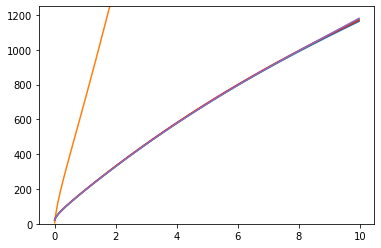

In [18]:
plt.plot(x,scss, label='scss')
plt.plot(x,scas, label='scas')
plt.plot(x,stot_om, label='s oneill')
plt.plot(x,stot_jug, label='s jugo')
plt.plot(x,stot_na, label='s nash')
plt.ylim(0,1250)

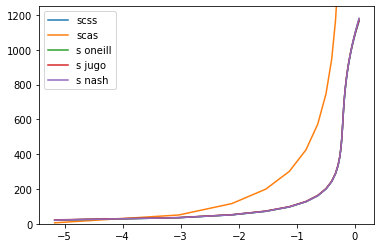

In [19]:
x = calcS_OM2022_GivenFe3['deltaQFM_calc']
plt.plot(x,scss, label='scss')
plt.plot(x,scas, label='scas')
plt.plot(x,stot_om, label='s oneill')
plt.plot(x,stot_jug, label='s jugo')
plt.plot(x,stot_na, label='s nash')
plt.ylim(0,1250)
plt.legend()

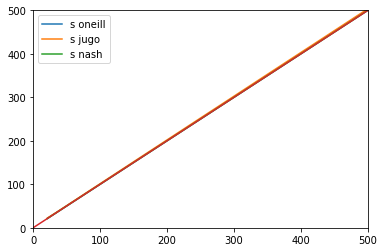

In [20]:
plt.plot(scss,stot_om, label='s oneill')
plt.plot(scss,stot_jug, label='s jugo')
plt.plot(scss,stot_na, label='s nash')
plt.plot([0,1200],[0,1200])
plt.ylim(0,500)
plt.xlim(0,500)
plt.legend()

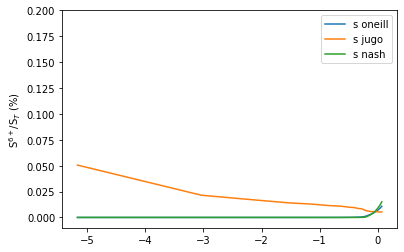

In [21]:
x = calcS_OM2022_GivenFe3['deltaQFM_calc']



#plt.plot(x,scss, label='scss')
#plt.plot(x,scas, label='scas')
plt.plot(x,df_ST_OM2022['S6_St'], label='s oneill')
plt.plot(x,df_ST_Jugo['S6_St'], label='s jugo')
plt.plot(x,df_ST_Nash['S6_St'], label='s nash')
plt.ylim(-0.01,0.2)
plt.ylabel('S$^{6+}$/S$_T$ (%)')
plt.legend()

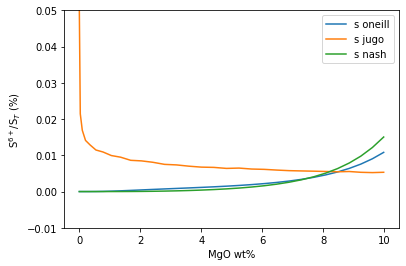

In [23]:
x = calcS_OM2022_GivenFe3['MgO_Liq']



#plt.plot(x,scss, label='scss')
#plt.plot(x,scas, label='scas')
plt.plot(x,df_ST_OM2022['S6_St'], label='s oneill')
plt.plot(x,df_ST_Jugo['S6_St'], label='s jugo')
plt.plot(df_x,df_ST_Nash['S6_St'], label='s nash')
plt.ylim(-0.01,0.05)
plt.ylabel('S$^{6+}$/S$_T$ (%)')
plt.xlabel('MgO wt%')
plt.legend()

In [33]:
all_data = pd.concat([df_out,scss,scas,stot_om,stot_jug,stot_na], axis=1)

In [39]:
all_data.head()

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,Ni_Liq_ppm,Cu_Liq_ppm,SiO2_magma,TiO2_magma,Al2O3_magma,Fe2O3_magma,FeO_magma,MnO_magma,MgO_magma,CaO_magma,Na2O_magma,K2O_magma,P2O5_magma,Cr2O3_magma,Ni_magma,Cu_magma,Cr2O3_Liq,Ni_Liq,Cu_Liq,SiO2_cumulate,TiO2_cumulate,Al2O3_cumulate,Fe2O3_cumulate,FeO_cumulate,MnO_cumulate,MgO_cumulate,CaO_cumulate,Na2O_cumulate,K2O_cumulate,P2O5_cumulate,Cr2O3_cumulate,Ni_cumulate,Cu_cumulate,Temperature,Temperature_Olv,Olv_Fo_magma,Olv_Kd,Olv_Fo_cumulate,Pressure(kbar),Lg(fO2),dNNO,density,Ln(viscosity),Melt_%_magma,Olv_%_magma,Olv_Peritectic,Fluid_%_magma,Olv_%_cumulate,Sample,Unnamed:58,T_K,P_kbar,SCSS_ideal_ppm_Smythe2017,Calc SCAS (ppm),Total_S,Total_S,Total_S
0,49.9010,0.9981,14.9715,8.980926,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0,0.098489,697.8,99.8,49.9010,0.9981,14.9715,0.9839,8.0964,0.0998,9.9763,11.9772,2.4953,0.1996,0.0998,0.0998,697.8,99.8,0.0998,697.8,99.8,40.2986,0,0,0,11.7372,0,46.9121,0,0,0,0,0,8257.6,10.0,1253.281,1253.281,87.69,0.308,87.69,1,-7.72,-0.7,2.683,6.25,99.9900,0,N,0,0.0100,PetrologDefault,08:21:15,1526.431,1,1163.632126,8797.905353,1176.354641,1169.857388,1181.411865
1,49.9978,1.0081,15.1220,8.951296,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.0,0.097851,624.6,100.7,49.9978,1.0081,15.1220,0.9743,8.0754,0.1008,9.6064,12.0976,2.5203,0.2016,0.1008,0.1008,624.6,100.7,0.1008,624.6,100.7,40.2698,0,0,0,11.9273,0,46.7855,0,0,0,0,0,7984.5,10.0,1243.430,1243.430,87.28,0.309,87.49,1,-7.83,-0.7,2.682,6.38,98.9950,0,N,0,1.0050,PetrologDefault,08:21:15,1516.580,1,1132.187652,8326.386148,1142.525512,1138.143086,1146.119468
2,50.0982,1.0185,15.2770,8.916645,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.0,0.097284,554.8,101.6,50.0982,1.0185,15.2770,0.9649,8.0492,0.1018,9.2279,12.2216,2.5462,0.2037,0.1018,0.1018,554.8,101.6,0.1018,554.8,101.6,40.2390,0,0,0,12.1280,0,46.6507,0,0,0,0,0,7708.8,10.1,1233.064,1233.064,86.83,0.310,87.27,1,-7.94,-0.7,2.681,6.52,97.9904,0,N,0,2.0096,PetrologDefault,08:21:15,1506.214,1,1099.523987,7863.650107,1107.919630,1105.398524,1110.380551
3,50.2003,1.0289,15.4337,8.877334,0.1029,8.8486,12.3469,2.5723,0.2058,0.1029,0.0,0.096823,489.9,102.6,50.2003,1.0289,15.4337,0.9561,8.0178,0.1029,8.8486,12.3469,2.5723,0.2058,0.1029,0.1029,489.9,102.6,0.1029,489.9,102.6,40.2069,0,0,0,12.3359,0,46.5096,0,0,0,0,0,7436.5,10.1,1222.361,1222.361,86.36,0.311,87.05,1,-8.05,-0.7,2.680,6.67,96.9959,0,N,0,3.0041,PetrologDefault,08:21:15,1495.511,1,1066.279038,7418.458243,1073.136664,1072.209449,1074.748164
4,50.3062,1.0397,15.5950,8.832002,0.1040,8.4612,12.4760,2.5992,0.2079,0.1040,0.0,0.096445,428.7,103.5,50.3062,1.0397,15.5950,0.9475,7.9802,0.1040,8.4612,12.4760,2.5992,0.2079,0.1040,0.1040,428.7,103.5,0.1040,428.7,103.5,40.1725,0,0,0,12.5558,0,46.3589,0,0,0,0,0,7162.8,10.2,1211.080,1211.080,85.84,0.312,86.81,1,-8.18,-0.7,2.679,6.83,95.9923,0,N,0,4.0077,PetrologDefault,08:21:15,1484.230,1,1031.735153,6981.487164,1037.336842,1037.394378,1038.301658


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


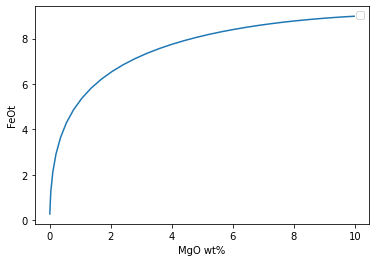

In [38]:
x = all_data['MgO_Liq']
y = all_data['FeOt_Liq']
#plt.plot(x,scss, label='scss')
#plt.plot(x,scas, label='scas')
plt.plot(x,y)#, label='s oneill')
plt.ylabel('FeOt')
plt.xlabel('MgO wt%')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


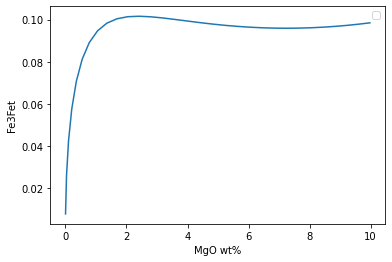

In [40]:
x = all_data['MgO_Liq']
y = all_data['Fe3Fet_Liq']
#plt.plot(x,scss, label='scss')
#plt.plot(x,scas, label='scas')
plt.plot(x,y)#, label='s oneill')
plt.ylabel('Fe3Fet')
plt.xlabel('MgO wt%')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


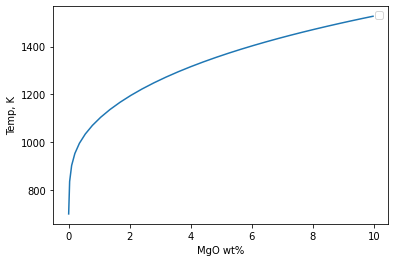

In [41]:
x = all_data['MgO_Liq']
y = all_data['T_K']
#plt.plot(x,scss, label='scss')
#plt.plot(x,scas, label='scas')
plt.plot(x,y)#, label='s oneill')
plt.ylabel('Temp, K')
plt.xlabel('MgO wt%')
plt.legend()

# My Data - testing O'Neill sens to water. 
# anhydrous normalisation - majors total 100% plus volatiles i.e. total > 100 wt%

In [104]:
ONEILL_df = pd.read_excel('/Users/ollie/Documents/Cambridge_2020/Earth_Sciences/MELTs/pyMELTScalc-0.0.12/Marchedit_MetalModel_noCO2_ONEILL.xlsx')
majors = ONEILL_df[['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeO_Liq','Fe2O3_Liq','FeOt_Liq', 'MnO_Liq', 'MgO_Liq',
       'CaO_Liq', 'Na2O_Liq', 'K2O_Liq', 'P2O5_Liq', 'H2O_Liq', 'Fe3Fet_Liq','T_C', 'pressure_bar','newcolumn']]
majors.columns = majors.columns.str.rstrip("_Liq")

In [105]:
majors.to_excel('Marchedit_modelmajors_unormalised.xlsx')

In [106]:
model_anhyd = pd.read_excel('/Users/ollie/Downloads/marchedit_anhydnorm_addvols.xlsx')

In [107]:
# modelled data as before but we have normalised to exclude water as O'Neill specifies
model_anhyd = model_anhyd.add_suffix('_Liq')

In [108]:
LiZhang22=ss.calculate_LZ2022_SCSS(df=model_anhyd, T_K=model_anhyd['T_C_Liq']+273.15, 
P_kbar=model_anhyd['pressure_bar_Liq']/1000,Fe_FeNiCu_Sulf=0.65,Fe3Fet_Liq=model_anhyd['Fe3Fet_Liq'], H2O_Liq=model_anhyd['H2O_Liq'])
LiZhang22.head()

replacing Fe3Fet_Liq in the original dataframe with that input into the function


,SCSS_Tot,Unnamed: 0_Liq,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeO_Liq,Fe2O3_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,FeOt_Liq,Fe3Fet_Liq,T_C_Liq,pressure_bar_Liq,newcolumn_Liq,lnCHS_NKA_term,NaKAl,DeltaGRT,SumXMAM,lnCs,lnXFeO,LnrFeO,lnaFeS,C1PC2erf,lnS,S2_calc,lnXH2Ot,KOH,XOH,lnXOH,XH2Om,lnXH2Om,lnXOH_XH2O,lnCHScalc,HScal,NaKAlterm,HScal2,Si_cat,Ti_cat,Al_cat,Fe_cat,Mn_cat,Mg_cat,Ca_cat,Na_cat,K_cat,P_cat,H_cat,Fe3_cat
0,1192.977683,0,48.996696,0.687149,12.846695,8.430678,1.652418,0.199174,12.876571,11.163678,1.981777,0.965992,0.199174,0.099488,9.917007,0.149779,1327.800000,2000,H2O_0.1_buff_0.15,-5.737781,-0.091913,6.846955,4.306419,-1.659963,2.742870,-0.377580,-0.497334,0.012474,7.067422,1173.119630,-6.206824,0.951757,0.003998,-5.522076,0.000017,-10.990684,-5.517868,-5.737781,19.858053,-1.530498,19.858053,0.447388,0.004720,0.138250,0.064385,0.001540,0.175278,0.109219,0.035085,0.011253,0.00154,0.0,0.011342
1,1176.668298,1,49.046514,0.691235,12.923093,8.418005,1.662245,0.198690,12.667187,11.227374,1.993562,0.971736,0.200358,0.100079,9.913177,0.150727,1322.817460,2000,H2O_0.1_buff_0.15,-5.765328,-0.092522,6.876099,4.311588,-1.700805,2.743702,-0.380799,-0.497277,0.012513,7.053434,1156.824137,-6.200983,0.948075,0.004021,-5.516316,0.000017,-10.975265,-5.512067,-5.765328,19.844161,-1.552096,19.844161,0.448144,0.004751,0.139166,0.064332,0.001538,0.172543,0.109916,0.035317,0.011327,0.00155,0.0,0.011417
2,1160.464187,2,49.096304,0.695306,12.999199,8.404547,1.672034,0.198188,12.459324,11.290798,2.005303,0.977459,0.201538,0.100668,9.908528,0.151685,1317.834921,2000,H2O_0.1_buff_0.15,-5.793270,-0.093128,6.905437,4.316665,-1.742026,2.744636,-0.384044,-0.497213,0.012552,7.039342,1140.636258,-6.195203,0.944373,0.004044,-5.510618,0.000017,-10.959933,-5.506328,-5.793270,19.827929,-1.573776,19.827929,0.448896,0.004782,0.140078,0.064272,0.001535,0.169824,0.110610,0.035549,0.011401,0.00156,0.0,0.011492
3,1144.392984,3,49.145880,0.699346,13.074727,8.390359,1.681749,0.197672,12.253755,11.353712,2.016954,0.983138,0.202709,0.101252,9.903084,0.152649,1312.852381,2000,H2O_0.1_buff_0.15,-5.821609,-0.093731,6.934968,4.321671,-1.783610,2.745668,-0.387308,-0.497142,0.012592,7.025168,1124.583565,-6.189505,0.940652,0.004066,-5.505002,0.000018,-10.944729,-5.500670,-5.821609,19.809419,-1.595475,19.809419,0.449644,0.004813,0.140984,0.064205,0.001532,0.167132,0.111299,0.035779,0.011475,0.00157,0.0,0.011566
4,1128.454983,4,49.195238,0.703355,13.149677,8.375448,1.691390,0.197139,12.050474,11.416117,2.028516,0.988774,0.203871,0.101832,9.896851,0.153620,1307.869841,2000,H2O_0.1_buff_0.15,-5.850344,-0.094329,6.964696,4.326606,-1.825558,2.746799,-0.390590,-0.497065,0.012631,7.010913,1108.666322,-6.183887,0.936911,0.004089,-5.499466,0.000018,-10.929651,-5.495094,-5.850344,19.788661,-1.617192,19.788661,0.450386,0.004844,0.141884,0.064133,0.001529,0.164465,0.111983,0.036007,0.011548,0.00158,0.0,0.011640


In [109]:
ZT22_SCAS=ss.calculate_ZT2022_SCAS(df=model_anhyd, T_K=model_anhyd['T_C_Liq']+273.15)
ZT22_SCAS.head()

,Calc SCAS (ppm),Unnamed: 0_Liq,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeO_Liq,Fe2O3_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,FeOt_Liq,Fe3Fet_Liq,T_C_Liq,pressure_bar_Liq,newcolumn_Liq
0,14347.641897,0,48.996696,0.687149,12.846695,8.430678,1.652418,0,12.876571,11.163678,1.981777,0.965992,0.199174,0.099488,9.917007,0.149779,1327.800000,2000,H2O_0.1_buff_0.15
1,13915.442554,1,49.046514,0.691235,12.923093,8.418005,1.662245,0,12.667187,11.227374,1.993562,0.971736,0.200358,0.100079,9.913177,0.150727,1322.817460,2000,H2O_0.1_buff_0.15
2,13499.181295,2,49.096304,0.695306,12.999199,8.404547,1.672034,0,12.459324,11.290798,2.005303,0.977459,0.201538,0.100668,9.908528,0.151685,1317.834921,2000,H2O_0.1_buff_0.15
3,13098.690854,3,49.145880,0.699346,13.074727,8.390359,1.681749,0,12.253755,11.353712,2.016954,0.983138,0.202709,0.101252,9.903084,0.152649,1312.852381,2000,H2O_0.1_buff_0.15
4,12713.210563,4,49.195238,0.703355,13.149677,8.375448,1.691390,0,12.050474,11.416117,2.028516,0.988774,0.203871,0.101832,9.896851,0.153620,1307.869841,2000,H2O_0.1_buff_0.15


In [110]:
calcS_OM2022_GivenFe3=ss.calculate_OM2022_S6St(df=model_anhyd, T_K=model_anhyd['T_C_Liq']+273.15,
                    Fe3Fet_Liq=model_anhyd['Fe3Fet_Liq'])

calcS_OM2022_GivenFe3.head()

,S6St_Liq,LnCS2_calc,LnKSO2S2,LnS6S2,deltaQFM_calc,Unnamed: 0_Liq,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeO_Liq,Fe2O3_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,FeOt_Liq,Fe3Fet_Liq,T_C_Liq,pressure_bar_Liq,newcolumn_Liq,SiO2_Liq_mol_frac,MgO_Liq_mol_frac,MnO_Liq_mol_frac,FeOt_Liq_mol_frac,CaO_Liq_mol_frac,Al2O3_Liq_mol_frac,Na2O_Liq_mol_frac,K2O_Liq_mol_frac,TiO2_Liq_mol_frac,P2O5_Liq_mol_frac,Si_Liq_cat_frac,Mg_Liq_cat_frac,Mn_Liq_cat_frac,Fet_Liq_cat_frac,Ca_Liq_cat_frac,Al_Liq_cat_frac,Na_Liq_cat_frac,K_Liq_cat_frac,Ti_Liq_cat_frac,P_Liq_cat_frac,Mg_Number_Liq_NoFe3,Mg_Number_Liq_Fe3,logfo2_calc,Fe2_Liq_cat_frac,LnCS6_calc
0,0.427557,-1.393366,-14.633203,-0.291827,0.927953,0,48.996696,0.687149,12.846695,8.430678,1.652418,0.199174,12.876571,11.163678,1.981777,0.965992,0.199174,0.099488,9.917007,0.149779,1327.800000,2000,H2O_0.1_buff_0.15,0.493296,0.193263,0.001698,0.083498,0.120426,0.076218,0.019343,0.006204,0.005204,0.000849,0.447388,0.175278,0.001540,0.075728,0.109219,0.138250,0.035085,0.011253,0.004720,0.00154,0.698296,0.731344,-6.140473,0.064385,11.959528
1,0.425570,-1.431987,-14.740257,-0.299949,0.931201,1,49.046514,0.691235,12.923093,8.418005,1.662245,0.198690,12.667187,11.227374,1.993562,0.971736,0.200358,0.100079,9.913177,0.150727,1322.817460,2000,H2O_0.1_buff_0.15,0.494465,0.190378,0.001697,0.083579,0.121277,0.076775,0.019484,0.006249,0.005242,0.000855,0.448144,0.172543,0.001538,0.075749,0.109916,0.139166,0.035317,0.011327,0.004751,0.00155,0.694912,0.728408,-6.186083,0.064332,12.015771
2,0.423702,-1.470978,-14.847989,-0.307596,0.934549,2,49.096304,0.695306,12.999199,8.404547,1.672034,0.198188,12.459324,11.290798,2.005303,0.977459,0.201538,0.100668,9.908528,0.151685,1317.834921,2000,H2O_0.1_buff_0.15,0.495632,0.187505,0.001695,0.083652,0.122126,0.077331,0.019625,0.006294,0.005280,0.000861,0.448896,0.169824,0.001535,0.075764,0.110610,0.140078,0.035549,0.011401,0.004782,0.00156,0.691493,0.725441,-6.231899,0.064272,12.072393
3,0.421941,-1.510327,-14.956404,-0.314808,0.937987,3,49.145880,0.699346,13.074727,8.390359,1.681749,0.197672,12.253755,11.353712,2.016954,0.983138,0.202709,0.101252,9.903084,0.152649,1312.852381,2000,H2O_0.1_buff_0.15,0.496791,0.184657,0.001692,0.083717,0.122970,0.077884,0.019765,0.006339,0.005318,0.000867,0.449644,0.167132,0.001532,0.075772,0.111299,0.140984,0.035779,0.011475,0.004813,0.00157,0.688051,0.722453,-6.277935,0.064205,12.129421
4,0.420291,-1.550036,-15.065508,-0.321580,0.941514,4,49.195238,0.703355,13.149677,8.375448,1.691390,0.197139,12.050474,11.416117,2.028516,0.988774,0.203871,0.101832,9.896851,0.153620,1307.869841,2000,H2O_0.1_buff_0.15,0.497945,0.181832,0.001690,0.083774,0.123808,0.078433,0.019905,0.006384,0.005355,0.000873,0.450386,0.164465,0.001529,0.075773,0.111983,0.141884,0.036007,0.011548,0.004844,0.00158,0.684585,0.719445,-6.324193,0.064133,12.186858


In [114]:
df_ST_OM2022=ss.calculate_S_Total_SCSS_SCAS(
    SCSS=LiZhang22['SCSS_Tot'],
    T_K=model_anhyd['T_C_Liq']+273.15,
    SCAS=ZT22_SCAS['Calc SCAS (ppm)'], S6St_Liq=calcS_OM2022_GivenFe3['S6St_Liq'])
df_ST_OM2022.head()

,Total_S,S2_Tot,S6_Tot,deltaQFM,S6_St,SCSS_2,SCAS_6,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,2084.010144,1192.977683,891.032462,None,0.427557,1192.977683,14347.641897,2084.010144,33557.286123,891.032462,19209.644227
1,2048.409850,1176.668298,871.741552,None,0.425570,1176.668298,13915.442554,2048.409850,32698.372035,871.741552,18782.929480
2,2013.651739,1160.464187,853.187551,None,0.423702,1160.464187,13499.181295,2013.651739,31860.110756,853.187551,18360.929460
3,1979.718204,1144.392984,835.325220,None,0.421941,1144.392984,13098.690854,1979.718204,31043.857067,835.325220,17945.166213
4,1946.587624,1128.454983,818.132641,None,0.420291,1128.454983,12713.210563,1946.587624,30248.613863,818.132641,17535.403300


In [115]:
model_anhyd.head()

,Unnamed: 0_Liq,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeO_Liq,Fe2O3_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,FeOt_Liq,Fe3Fet_Liq,T_C_Liq,pressure_bar_Liq,newcolumn_Liq
0,0,48.996696,0.687149,12.846695,8.430678,1.652418,0.199174,12.876571,11.163678,1.981777,0.965992,0.199174,0.099488,9.917007,0.149779,1327.800000,2000,H2O_0.1_buff_0.15
1,1,49.046514,0.691235,12.923093,8.418005,1.662245,0.198690,12.667187,11.227374,1.993562,0.971736,0.200358,0.100079,9.913177,0.150727,1322.817460,2000,H2O_0.1_buff_0.15
2,2,49.096304,0.695306,12.999199,8.404547,1.672034,0.198188,12.459324,11.290798,2.005303,0.977459,0.201538,0.100668,9.908528,0.151685,1317.834921,2000,H2O_0.1_buff_0.15
3,3,49.145880,0.699346,13.074727,8.390359,1.681749,0.197672,12.253755,11.353712,2.016954,0.983138,0.202709,0.101252,9.903084,0.152649,1312.852381,2000,H2O_0.1_buff_0.15
4,4,49.195238,0.703355,13.149677,8.375448,1.691390,0.197139,12.050474,11.416117,2.028516,0.988774,0.203871,0.101832,9.896851,0.153620,1307.869841,2000,H2O_0.1_buff_0.15


In [116]:
import Thermobar as pt

calc_fo2=pt.convert_fe_partition_to_fo2(liq_comps=model_anhyd,
                                        T_K=model_anhyd['T_C_Liq']+273.15, 
                                        P_kbar=model_anhyd['pressure_bar_Liq']/1000, 
                                        model="Kress1991", renorm=False)
calc_fo2.tail()


,DeltaQFM,DeltaNNO,fo2_calc,Unnamed: 0_Liq,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeO_Liq,Fe2O3_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,FeOt_Liq,Fe3Fet_Liq,T_C_Liq,pressure_bar_Liq,newcolumn_Liq
1175,-5.197479,-5.949425,7.564017e-21,1175,75.598748,0.153481,7.240460,1.421022,0.057304,0.384459,0.001605,3.490536,5.614142,5.267230,0.771012,3.126207,1.426862,0.035007,785.290991,500,H2O_6.0_buff_0.25
1176,-5.367962,-6.120512,3.940860e-21,1176,75.904737,0.145052,7.040055,1.368237,0.051684,0.393109,0.000524,3.486473,5.664991,5.171931,0.773205,3.144523,1.370539,0.032865,780.273874,500,H2O_6.0_buff_0.25
1177,-5.550136,-6.303296,1.993698e-21,1177,76.207814,0.137022,6.846877,1.309196,0.046091,0.401606,0.000088,3.479884,5.716597,5.078682,0.776143,3.162645,1.308205,0.030699,775.256757,500,H2O_6.0_buff_0.25
1178,-5.780146,-6.533923,9.011505e-22,1178,76.492672,0.129165,6.650823,1.236046,0.039774,0.412830,0.000003,3.473934,5.798248,4.988011,0.778494,3.184157,1.231555,0.028134,770.239640,500,H2O_6.0_buff_0.25
1179,NaN,NaN,NaN,1179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,765.222523,500,H2O_6.0_buff_0.25


In [117]:
df_ST_Jugo=ss.calculate_S_Total_SCSS_SCAS(deltaQFM=calc_fo2.DeltaQFM,
            SCSS=LiZhang22['SCSS_Tot'], SCAS=ZT22_SCAS['Calc SCAS (ppm)'], model='Jugo')
df_ST_Jugo.head()

,Total_S,S2_Tot,S6_Tot,deltaQFM,S6_St,SCSS_2,SCAS_6,SCSS_Tot,SCAS_Tot,S6 in SCSS_Tot,S2 in SCAS_Tot
0,1203.003835,1192.977683,10.026153,0.012251,0.008334,1192.977683,14347.641897,1203.003835,1.721525e+06,10.026153,1.707177e+06
1,1186.984256,1176.668298,10.315959,0.021428,0.008691,1176.668298,13915.442554,1186.984256,1.601151e+06,10.315959,1.587236e+06
2,1171.076402,1160.464187,10.612215,0.030587,0.009062,1160.464187,13499.181295,1171.076402,1.489658e+06,10.612215,1.476159e+06
3,1155.306182,1144.392984,10.913199,0.039688,0.009446,1144.392984,13098.690854,1155.306182,1.386669e+06,10.913199,1.373571e+06
4,1139.673875,1128.454983,11.218892,0.048733,0.009844,1128.454983,12713.210563,1139.673875,1.291475e+06,11.218892,1.278761e+06


# Original data, norm to 100 wt% including volatiles
# water will dilute the majors - 

In [119]:
# unorm here
ONEILL_df[['DeltaQFM', 'S_total_lizOM', 'S_total_lizJUGO', 'S_total_lizNASH',
       'S6St_lizOM', 'S6St_lizJUGO', 'S6St_lizNASH', 'Calc SCAS (ppm)',
       'SCSS_Tot','MgO_Liq','FeO_Liq','Fe2O3_Liq', 'Fe3Fet_Liq', 'pressure_bar', 'newcolumn','unique']]

,DeltaQFM,S_total_lizOM,S_total_lizJUGO,S_total_lizNASH,S6St_lizOM,S6St_lizJUGO,S6St_lizNASH,Calc SCAS (ppm),SCSS_Tot,MgO_Liq,FeO_Liq,Fe2O3_Liq,Fe3Fet_Liq,pressure_bar,newcolumn,unique
0,0.012253,2084.147309,1203.524517,3851.030463,4.273466e-01,8.334326e-03,6.900845e-01,14338.942883,1193.493952,12.863760,8.422291,1.650774,0.149779,2000,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
1,0.021429,2048.554125,1187.503666,3757.140131,4.253590e-01,8.690963e-03,6.866811e-01,13906.964588,1177.183116,12.654510,8.409581,1.660582,0.150727,2000,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
2,0.030589,2013.802549,1171.594350,3665.337367,4.234900e-01,9.062001e-03,6.832550e-01,13490.915532,1160.977360,12.446781,8.396086,1.670351,0.151685,2000,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
3,0.039690,1979.874997,1155.822483,3575.129724,4.217290e-01,9.446227e-03,6.797587e-01,13090.628678,1144.904322,12.241348,8.381863,1.680046,0.152649,2000,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
4,0.048735,1946.749862,1140.188345,3486.530460,4.200774e-01,9.844028e-03,6.761926e-01,12705.343793,1128.964298,12.038203,8.366919,1.689667,0.153620,2000,H2O_0.1_buff_0.15,P_2000.0_H2O_0.1_buff_0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,-5.193901,577.333105,577.333086,577.333086,3.282092e-08,3.252350e-13,2.406197e-10,209.384413,577.333086,0.001554,1.376598,0.055513,0.035007,500,H2O_6.0_buff_0.25,P_500.0_H2O_6.0_buff_0.25
1176,-5.364337,622.596929,622.596917,622.596917,1.948510e-08,1.483631e-13,1.270973e-10,201.087302,622.596917,0.000508,1.325213,0.050059,0.032865,500,H2O_6.0_buff_0.25,P_500.0_H2O_6.0_buff_0.25
1177,-5.546464,673.341095,673.341088,673.341088,1.111652e-08,6.413158e-14,6.445523e-11,192.969629,673.341088,0.000085,1.267791,0.044633,0.030699,500,H2O_6.0_buff_0.25,P_500.0_H2O_6.0_buff_0.25
1178,-5.776405,751.119257,751.119252,751.119252,5.419156e-09,2.224278e-14,2.795959e-11,185.314074,751.119252,0.000003,1.196689,0.038507,0.028134,500,H2O_6.0_buff_0.25,P_500.0_H2O_6.0_buff_0.25


In [125]:
model_anhyd['scss'] = LiZhang22['SCSS_Tot']
model_anhyd['scas'] = ZT22_SCAS['Calc SCAS (ppm)']
model_anhyd['S_total_lizOM'] = df_ST_OM2022['Total_S']
model_anhyd['S6St_lizOM'] = df_ST_OM2022['S6_St']

model_anhyd['S_total_lizJUGO'] = df_ST_Jugo['Total_S']
model_anhyd['S6St_lizJUGO'] = df_ST_Jugo['S6_St']
model_anhyd.head()

,Unnamed: 0_Liq,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeO_Liq,Fe2O3_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,FeOt_Liq,Fe3Fet_Liq,T_C_Liq,pressure_bar_Liq,newcolumn_Liq,scss,scas,S_total_lizOM,S6St_lizOM,S_total_lizJUGO,S6St_lizJUGO
0,0,48.996696,0.687149,12.846695,8.430678,1.652418,0.199174,12.876571,11.163678,1.981777,0.965992,0.199174,0.099488,9.917007,0.149779,1327.800000,2000,H2O_0.1_buff_0.15,1192.977683,14347.641897,2084.010144,0.427557,1203.003835,0.008334
1,1,49.046514,0.691235,12.923093,8.418005,1.662245,0.198690,12.667187,11.227374,1.993562,0.971736,0.200358,0.100079,9.913177,0.150727,1322.817460,2000,H2O_0.1_buff_0.15,1176.668298,13915.442554,2048.409850,0.425570,1186.984256,0.008691
2,2,49.096304,0.695306,12.999199,8.404547,1.672034,0.198188,12.459324,11.290798,2.005303,0.977459,0.201538,0.100668,9.908528,0.151685,1317.834921,2000,H2O_0.1_buff_0.15,1160.464187,13499.181295,2013.651739,0.423702,1171.076402,0.009062
3,3,49.145880,0.699346,13.074727,8.390359,1.681749,0.197672,12.253755,11.353712,2.016954,0.983138,0.202709,0.101252,9.903084,0.152649,1312.852381,2000,H2O_0.1_buff_0.15,1144.392984,13098.690854,1979.718204,0.421941,1155.306182,0.009446
4,4,49.195238,0.703355,13.149677,8.375448,1.691390,0.197139,12.050474,11.416117,2.028516,0.988774,0.203871,0.101832,9.896851,0.153620,1307.869841,2000,H2O_0.1_buff_0.15,1128.454983,12713.210563,1946.587624,0.420291,1139.673875,0.009844


In [121]:
model_anhyd['S_total_lizOM'],ONEILL_df['S_total_lizOM']

(0       2084.010144
 1       2048.409850
 2       2013.651739
 3       1979.718204
 4       1946.587624
            ...     
 1175     587.836760
 1176     634.296648
 1177     686.443459
 1178     766.372899
 1179            NaN
 Name: S_total_lizOM, Length: 1180, dtype: float64,
 0       2084.147309
 1       2048.554125
 2       2013.802549
 3       1979.874997
 4       1946.749862
            ...     
 1175     577.333105
 1176     622.596929
 1177     673.341095
 1178     751.119257
 1179       0.000000
 Name: S_total_lizOM, Length: 1180, dtype: float64)

In [122]:
# reds color dict for Jugo 
reds = ['#ff80b3','#99003d','#4d001f','#e6005c']
jugo_dict = dict(zip(model_anhyd.newcolumn_Liq.unique(),reds))
# blues color dict for ONeill
blues =[ '#b3d9ff','#0059b3','#00264d','#1a8cff']
om_dict = dict(zip(ONEILL_df.newcolumn.unique(),blues))

# dict for linestyle
pressure = ONEILL_df['pressure_bar'].unique()
lines = ['solid', 'dashdot', 'dashed']
pdict = dict(zip(pressure, lines))

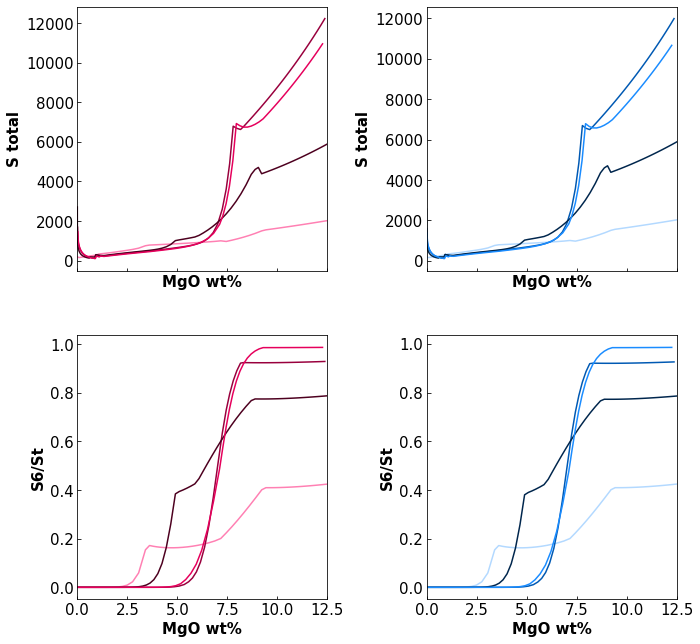

In [123]:
fig, ax = plt.subplots(2,2, sharex = True)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12
pressure = [2000]#ONEILL_df.pressure_bar.unique()

for v in ONEILL_df.newcolumn.unique():
    df_v = ONEILL_df[ONEILL_df.newcolumn == v]
    df_j = model_anhyd[model_anhyd.newcolumn_Liq == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        df_jp = df_j[df_j.pressure_bar_Liq == p]
        x = df_vp['MgO_Liq']
        ax[0,1].plot(x, df_vp['S_total_lizOM'], color=om_dict[v], label='unorm', linestyle=pdict[p])
        #ax[0,1].plot(x, df_vp['Calc SCAS (ppm)'], color=om_dict[v], label=v, linestyle=pdict[p])
        #ax[1,0].plot(x, df_vp['SCSS_Tot'], color=om_dict[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['S6St_lizOM'], color=om_dict[v], label=v, linestyle=pdict[p])
        
       # normlaised now in pinks
        ax[0,0].plot(x, df_jp['S_total_lizOM'], color=jugo_dict[v], label='norm anhyd', linestyle=pdict[p])
        #ax[0,1].plot(x, df_jp['scas'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        #ax[1,0].plot(x, df_jp['scss'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_jp['S6St_lizOM'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        
ax = ax.flatten()
for i in range(4):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,12.5)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('S total', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('S total', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('S6/St', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('S6/St', fontsize=15, weight='bold')

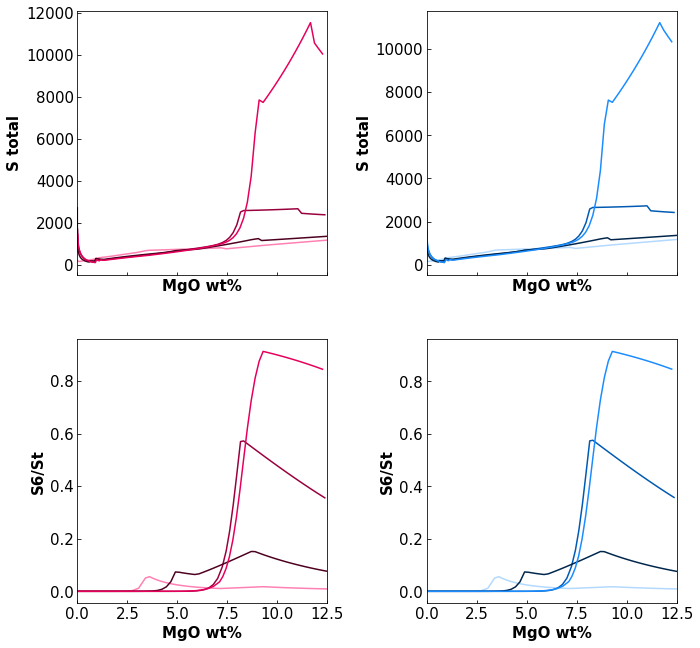

In [126]:
fig, ax = plt.subplots(2,2, sharex = True)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12
pressure = [2000]#ONEILL_df.pressure_bar.unique()

for v in ONEILL_df.newcolumn.unique():
    df_v = ONEILL_df[ONEILL_df.newcolumn == v]
    df_j = model_anhyd[model_anhyd.newcolumn_Liq == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        df_jp = df_j[df_j.pressure_bar_Liq == p]
        x = df_vp['MgO_Liq']
        ax[0,1].plot(x, df_vp['S_total_lizJUGO'], color=om_dict[v], label='unorm', linestyle=pdict[p])
        #ax[0,1].plot(x, df_vp['Calc SCAS (ppm)'], color=om_dict[v], label=v, linestyle=pdict[p])
        #ax[1,0].plot(x, df_vp['SCSS_Tot'], color=om_dict[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['S6St_lizJUGO'], color=om_dict[v], label=v, linestyle=pdict[p])
        
       # normlaised now in pinks
        ax[0,0].plot(x, df_jp['S_total_lizJUGO'], color=jugo_dict[v], label='norm anhyd', linestyle=pdict[p])
        #ax[0,1].plot(x, df_jp['scas'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        #ax[1,0].plot(x, df_jp['scss'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_jp['S6St_lizJUGO'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        
ax = ax.flatten()
for i in range(4):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,12.5)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('S total', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('S total', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('S6/St', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('S6/St', fontsize=15, weight='bold')

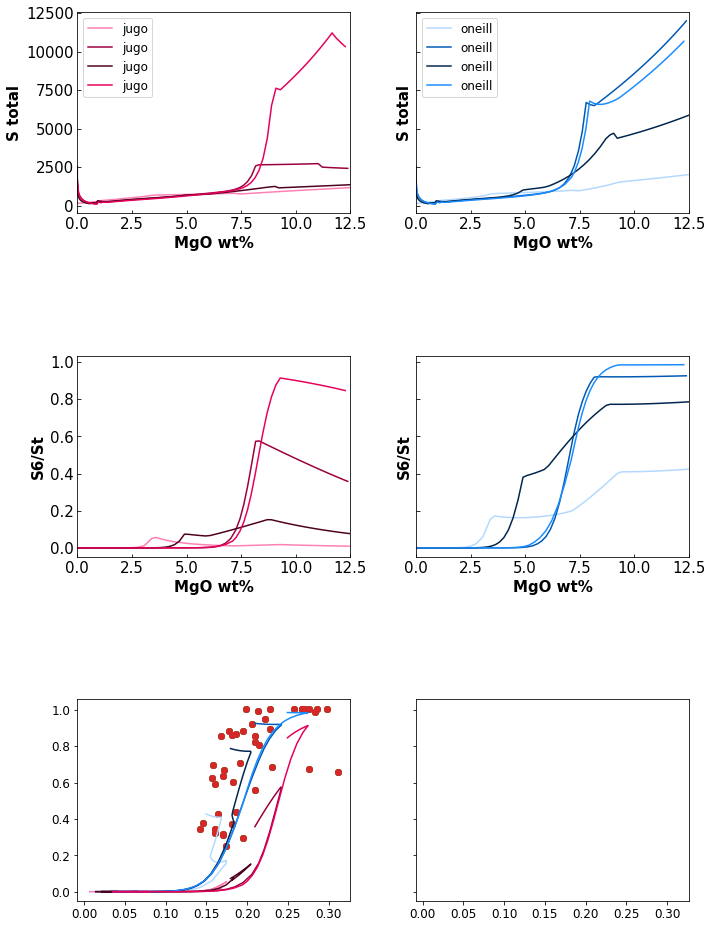

In [150]:
fig, ax = plt.subplots(3,2, sharex='row', sharey='row')
fig.tight_layout()
fig.set_figheight(15)
fig.set_figwidth(10)
plt.rcParams["font.family"] ="sans-serif" 
plt.rcParams["font.size"] = 12
pressure = [2000]#ONEILL_df.pressure_bar.unique()

for v in ONEILL_df.newcolumn.unique():
    df_v = ONEILL_df[ONEILL_df.newcolumn == v]
    df_j = ONEILL_df[ONEILL_df.newcolumn == v]
    for p in pressure:
        df_vp = df_v[df_v.pressure_bar == p]
        df_jp = df_j[df_j.pressure_bar == p]
        x = df_vp['MgO_Liq']
        ax[0,1].plot(x, df_vp['S_total_lizOM'], color=om_dict[v], label='oneill', linestyle=pdict[p])
        #ax[0,1].plot(x, df_vp['Calc SCAS (ppm)'], color=om_dict[v], label=v, linestyle=pdict[p])
        #ax[1,0].plot(x, df_vp['SCSS_Tot'], color=om_dict[v], label=v, linestyle=pdict[p])
        ax[1,1].plot(x, df_vp['S6St_lizOM'], color=om_dict[v], label=v, linestyle=pdict[p])
        ax[0,1].legend()
       # normlaised now in pinks
        ax[0,0].plot(x, df_jp['S_total_lizJUGO'], color=jugo_dict[v], label='jugo', linestyle=pdict[p])
        #ax[0,1].plot(x, df_jp['scas'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        #ax[1,0].plot(x, df_jp['scss'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        ax[1,0].plot(x, df_jp['S6St_lizJUGO'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        ax[0,0].legend()
        
        ax[2,0].plot(df_vp['Fe3Fet_Liq'], df_vp['S6St_lizOM'], color=om_dict[v], label='oneill', linestyle=pdict[p])
        #ax[0,1].plot(x, df_jp['scas'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        #ax[1,0].plot(x, df_jp['scss'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        ax[2,0].plot(df_jp['Fe3Fet_Liq'], df_jp['S6St_lizJUGO'], color=jugo_dict[v], label=v, linestyle=pdict[p])
        
        ax[2,0].scatter(Muth_2021['Fe3+/∑ Fe'], Muth_2021['S6+/∑S'])
ax = ax.flatten()
for i in range(4):
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in')
    ax[i].set_xlim(0,12.5)
    ax[i].set_xlabel('MgO wt%', fontsize=15,weight='bold')
    if i == 0:
        ax[i].set_ylabel('S total', fontsize=15, weight='bold')
    if i == 1:
        ax[i].set_ylabel('S total', fontsize=15, weight='bold')
    if i == 2:
        ax[i].set_ylabel('S6/St', fontsize=15, weight='bold')
    if i == 3:
        ax[i].set_ylabel('S6/St', fontsize=15, weight='bold')
   

In [147]:
# read in Muth and Wallace Lassen data - recent XANES
Muth_2021 = pd.read_excel('/Users/ollie/Downloads/14699628/G48759_SuppTabsS1-S14/TableS5 - XANES Data.xlsx', sheet_name='muth_2021_XANES')

In [148]:
Muth_2021.head()

,cinder cone,sample,S6+/∑S,Fe3+/∑ Fe,log (fO2),Δ QFM
0,BAS44,BAS442,0.414778,NaN,NaN,NaN
1,BAS44,BAS442,0.316135,0.169955,NaN,NaN
2,BAS44,BAS442,0.379671,0.146247,NaN,NaN
3,BAS44,BAS442,0.586993,NaN,NaN,NaN
4,BAS44,BAS442,0.600600,NaN,NaN,NaN
